In [3]:
import pandas as pd

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [5]:
APP_NAME = "Survival Analysis with Deep Learning"

try:
    sc.stop()
    spark.stop()
except:
    pass

from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

try:
    sc and spark
except (NameError, UnboundLocalError) as e:
    import findspark
    #findspark.init()
    import pyspark
    import pyspark.sql
    
    #sc = pyspark.SparkContext()
    #spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
    
sc = SparkContext(conf = SparkConf() .set("spark.driver.maxResultSize", "60g") .set("spark.sql.execution.arrow.enabled", "true") .set('spark.sql.broadcastTimeout', 1000) .set('spark.local.dir', '/data_data/session_length/spark_tmp/') .set('spark.driver.memory', '60G') .set("spark.executor.instances", "10") .set("spark.executor.cores", 10) .set("spark.executor.memory", "20G")).getOrCreate()
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")
    

In [6]:
sc._conf.getAll()

[(u'spark.local.dir', u'/data_data/session_length/spark_tmp/'),
 (u'spark.driver.maxResultSize', u'60g'),
 (u'spark.sql.execution.arrow.enabled', u'true'),
 (u'spark.executor.id', u'driver'),
 (u'spark.executor.cores', u'10'),
 (u'spark.app.name', u'pyspark-shell'),
 (u'spark.executor.memory', u'20G'),
 (u'spark.executor.instances', u'10'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.driver.host', u'ip-172-31-41-62.ec2.internal'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.master', u'local[*]'),
 (u'spark.driver.memory', u'60G'),
 (u'spark.driver.port', u'45268'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.app.id', u'local-1541454408192'),
 (u'spark.sql.broadcastTimeout', u'1000'),
 (u'spark.ui.showConsoleProgress', u'true')]

In [7]:
from pyspark.sql.types import StructField, StructType, StringType, LongType, DateType, DoubleType, IntegerType, TimestampType
from pyspark.sql.functions import count, mean, stddev_pop, min, max, lit, round, bround, pow, col, corr, lower, upper, avg, stddev, abs, log
from pyspark.sql.functions import lit, trim, rtrim, rpad, trim, coalesce
from pyspark.sql.functions import current_date, current_timestamp, date_add, date_sub, months_between, to_date
from pyspark.sql.functions import udf, col, countDistinct, lag
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, dense_rank, rank, expr

from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula, Bucketizer, QuantileDiscretizer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier,NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.linalg import Vectors

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### IMPORT SESSION DATA

In [283]:
!ls -alrth | grep session

In [9]:
!head session_with_time_of_day_ALL2.csv

"userid"	["'timestam'", "'artid'", "'artname_'", "'traid'", "'traname_'", "'session_window'", "'gender'", "'age'", "'country'", "'registered'", "'reg_date'", "None", "'Null'", "'Null'", "'Null'"]
"user_000001"	["'2009-05-04T23:08:57'", "'f1b1cf71-bd35-4e99-8624-24a6e15f133a'", "'Deep Dish'", "''", "'Fuck Me Im Famous (Pacha Ibiza)-09-28-2007'", "'23'", "'m'", "''", "'Japan'", "'Aug 13, 2006'", "'2006-08-13'", "<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>", "datetime.datetime(2009, 5, 5, 17, 8, 57, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)", "'LateAfternoon'", "'Tuesday'"]
"user_000001"	["'2009-05-04T13:54:10'", "'a7f7df4a-77d8-4f12-8acd-5c60c93f4de8'", "'\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80'", "''", "'Composition 0919 (Live_2009_4_15)'", "'13'", "'m'", "''", "'Japan'", "'Aug 13, 2006'", "'2006-08-13'", "<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>", "datetime.datetime(2009, 5, 5, 7, 54, 10, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)", "'Morning'", "'Tuesday

In [279]:
!head session_with_time_of_day_ALL2.csv | sed "s/|//g" | awk  '{gsub("\t","|",$0); print;}'| awk  '{gsub(", \"","|",$0); print;}'    | sed  's/\[//g' | sed  's/\]//g' | sed  "s/\"'//g" | sed  "s/'\"//g" | sed "s/|'/|/g" | sed "s/|<Dst/|\"<Dst/g" | sed "s/|datetime/|\"datetime/g" | sed "s/None\"/\"\"/g" | sed "s/\\x/\\x/g" | sed "s/\"user/user/g" | sed "s/\"|/|/g" | sed "s/|\"/|/g"

In [11]:
!rm session_with_time_of_day_all_.csv
!cat session_with_time_of_day_ALL2.csv | sed "s/|//g" | awk  '{gsub("\t","|",$0); print;}'| awk  '{gsub(", \"","|",$0); print;}'    | sed  's/\[//g' | sed  's/\]//g' | sed  "s/\"'//g" | sed  "s/'\"//g" | sed "s/|'/|/g" | sed "s/|<Dst/|\"<Dst/g" | sed "s/|datetime/|\"datetime/g" | sed "s/None\"/\"\"/g" | sed "s/\\x/\\x/g" | sed "s/\"user/user/g" | sed "s/\"|/|/g" | sed "s/|\"/|/g" | sed "s/||/|Null|/g" > session_with_time_of_day_all_.csv

In [280]:
!head -n 20 session_with_time_of_day_all_.csv

In [13]:
!ls -alrth  session_with_time_of_day_all_.csv 

-rw-r--r-- 1 hduser hadoop 5.8G Nov  5 21:49 session_with_time_of_day_all_.csv


In [14]:
#!rm test.csv
#!head -n 1000000 session_with_time_of_day_all_.csv > test.csv

In [275]:
raw_sess_df = pd.read_csv('session_with_time_of_day_all_.csv',sep='|',header=None, error_bad_lines = False)
raw_sess_df

In [16]:
# raw_sess_df.to_csv('/data_data/session_length/session_with_time_of_day_ALL_.csv', index=False, sep=",")

In [17]:
#!head session_with_time_of_day_ALL_.csv

In [18]:
#!rm session_with_time_of_day_ALL_.csv
#!cat session_with_time_of_day_ALL.csv | awk  '{gsub("\"\"\"","\"",$0); print;}' > session_with_time_of_day_ALL_.csv

In [19]:
#!head  session_with_time_of_day_ALL_.csv

In [20]:
raw_sess_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,userid,timestam,artid,artname_,traid,traname_,session_window,gender,age,country,registered,reg_date,Null,Null,Null,Null
1,user_000001,2009-05-04T23:08:57,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,Null,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,23,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 17, 8, 57, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",LateAfternoon,Tuesday
2,user_000001,2009-05-04T13:54:10,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80,Null,Composition 0919 (Live_2009_4_15),13,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 7, 54, 10, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",Morning,Tuesday
3,user_000001,2009-05-04T13:52:04,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80,Null,Mc2 (Live_2009_4_15),13,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 7, 52, 4, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",Morning,Tuesday
4,user_000001,2009-05-04T13:42:52,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80,Null,Hibari (Live_2009_4_15),13,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 7, 42, 52, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",Morning,Tuesday


In [21]:
raw_sess_df.columns = ["userid","timestamp","artid","artname_","traid","traname_","session_window","gender","age","country","registered","reg_date","timezone","session_start","time_of_day","day_of_week"]

In [22]:
raw_sess_df = raw_sess_df.iloc[1:,:]
raw_sess_df.head()

,userid,timestamp,artid,artname_,traid,traname_,session_window,gender,age,country,registered,reg_date,timezone,session_start,time_of_day,day_of_week
1,user_000001,2009-05-04T23:08:57,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,Null,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,23,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 17, 8, 57, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",LateAfternoon,Tuesday
2,user_000001,2009-05-04T13:54:10,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80,Null,Composition 0919 (Live_2009_4_15),13,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 7, 54, 10, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",Morning,Tuesday
3,user_000001,2009-05-04T13:52:04,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80,Null,Mc2 (Live_2009_4_15),13,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 7, 52, 4, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",Morning,Tuesday
4,user_000001,2009-05-04T13:42:52,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80,Null,Hibari (Live_2009_4_15),13,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 7, 42, 52, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",Morning,Tuesday
5,user_000001,2009-05-04T13:42:11,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,\\xe5\\x9d\\x82\\xe6\\x9c\\xac\\xe9\\xbe\\x8d\\xe4\\xb8\\x80,Null,Mc1 (Live_2009_4_15),13,m,Null,Japan,"Aug 13, 2006",2006-08-13,<DstTzInfo 'Asia/Tokyo' LMT+9:19:00 STD>,"datetime.datetime(2009, 5, 5, 7, 42, 11, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)",Morning,Tuesday


In [23]:
raw_session_data_df = None

In [24]:
def import_raw_session_data():
    print("==================================================================================================================")
    print("========================================    IMPORTING RAW SESSION DATA     ======================================")
    print("==================================================================================================================\n\n")
    global raw_session_data_df
    sessionSchema = StructType([
        StructField('userid', StringType(), True),\
        StructField('timestamp', StringType(), True),\
        StructField('artid', StringType(),True),\
        StructField('artname_', StringType(),True),\
        StructField('traid', StringType(),True),\
        StructField('traname_',StringType(),True),\
        StructField('session_window',StringType(),True),\
        StructField('gender', StringType(),True),\
        StructField('age', StringType(), True),\
        StructField('country', StringType(), True),\
        StructField('registered', StringType(), True),\
        StructField('reg_date', StringType(), True),\
        StructField('timezone', StringType(), True),\
        StructField('session_start', StringType(), True),\
        StructField('time_of_day', StringType(), True),\
        StructField('day_of_week', StringType(), True)
        ])
    #raw_session_data_df = spark.read.format('csv').options(sep='.').schema(sessionSchema).option('header',False).load('session_with_time_of_day_all_.csv')
    raw_session_data_df= spark.createDataFrame(raw_sess_df, sessionSchema)
    

In [25]:
import_raw_session_data()

========================================    IMPORTING RAW SESSION DATA     ======================================




/usr/local/lib/python2.7/dist-packages/pyspark/sql/session.py:663: UserWarning: Arrow will not be used in createDataFrame: Expected a string or bytes object, got a 'int' object
  warnings.warn("Arrow will not be used in createDataFrame: %s" % str(e))


In [281]:
raw_session_data_df.show(30, False)

In [27]:
raw_session_data_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- artid: string (nullable = true)
 |-- artname_: string (nullable = true)
 |-- traid: string (nullable = true)
 |-- traname_: string (nullable = true)
 |-- session_window: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- country: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- reg_date: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- session_start: string (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- day_of_week: string (nullable = true)



In [28]:
!whoami

hduser


### JOIN GENRE DATA

In [29]:
!head -n 5 genres_file.csv
genres_df = None

","	["bf710b71-48e5-4e15-9bd6-96debb2e4e98", "electro", "swedish", "electronic"]
","	["a94a7155-c79d-4409-9fcf-220cb0e4dc3a", "new wave", "rock", "alternative"]
","	["d41a6875-b626-4c0f-89a1-aecb643d29ff", "irish", "folk", "folk rock"]
","	["5441c29d-3602-4898-b1a1-b77fa23b8e50", "ambient", "instrumental", "70s"]
","	["5dedf5cf-a598-4408-9556-3bf3f149f3ba", "hard rock", "classic rock", "rock"]


In [30]:
!head genres_file.csv | sed 's/\t/,/g' | sed 's/\[//g' | sed 's/\]//g' | sed 's/\",\",//g'

"bf710b71-48e5-4e15-9bd6-96debb2e4e98", "electro", "swedish", "electronic"
"a94a7155-c79d-4409-9fcf-220cb0e4dc3a", "new wave", "rock", "alternative"
"d41a6875-b626-4c0f-89a1-aecb643d29ff", "irish", "folk", "folk rock"
"5441c29d-3602-4898-b1a1-b77fa23b8e50", "ambient", "instrumental", "70s"
"5dedf5cf-a598-4408-9556-3bf3f149f3ba", "hard rock", "classic rock", "rock"
"36bfa85f-737b-41db-a8fc-b8825850ffc3", "indie", "indie rock", "lo-fi"
"d43d12a1-2dc9-4257-a2fd-0a3bb1081b86", "country", "folk", "johnny cash"
"f41490ce-fe39-435d-86c0-ab5ce098b423", "80s", "new wave", "rock"
"9e53f84d-ef44-4c16-9677-5fd4d78cbd7d", "rock", "alt-country", "alt country"
"d8915e13-d67a-4aa0-9c0b-1f126af951af", "electronic", "british i like", "electronica"


In [31]:
!rm genresList.csv
!cat genres_file.csv | sed 's/\t/,/g' | sed 's/\[//g' | sed 's/\]//g' | sed 's/\",\",//g' > genresList.csv
!head genresList.csv

"bf710b71-48e5-4e15-9bd6-96debb2e4e98", "electro", "swedish", "electronic"
"a94a7155-c79d-4409-9fcf-220cb0e4dc3a", "new wave", "rock", "alternative"
"d41a6875-b626-4c0f-89a1-aecb643d29ff", "irish", "folk", "folk rock"
"5441c29d-3602-4898-b1a1-b77fa23b8e50", "ambient", "instrumental", "70s"
"5dedf5cf-a598-4408-9556-3bf3f149f3ba", "hard rock", "classic rock", "rock"
"36bfa85f-737b-41db-a8fc-b8825850ffc3", "indie", "indie rock", "lo-fi"
"d43d12a1-2dc9-4257-a2fd-0a3bb1081b86", "country", "folk", "johnny cash"
"f41490ce-fe39-435d-86c0-ab5ce098b423", "80s", "new wave", "rock"
"9e53f84d-ef44-4c16-9677-5fd4d78cbd7d", "rock", "alt-country", "alt country"
"d8915e13-d67a-4aa0-9c0b-1f126af951af", "electronic", "british i like", "electronica"


In [32]:
genres_df = None

In [33]:
def import_genres():
    print("==================================================================================================================")
    print("========================================     IMPORTING   GENRES .  DATA     ======================================")
    print("==================================================================================================================\n\n")
    global genres_df
    sessionSchema = StructType([
        StructField('trackid_', StringType(), True),\
        StructField('genre_1', StringType(), True),\
        StructField('genre_2', StringType(), True),\
        StructField('genre_3', StringType(), True)
        ])
    genres_df = spark.read.format('csv').schema(sessionSchema).option('header',False).load('/data_data/session_length/genresList.csv')

In [34]:
import_genres()
genres_df.sample(0.001,10).show(10, False)

========================================     IMPORTING   GENRES .  DATA     ======================================


+------------------------------------+--------------------+-----------------------+----------------+
|trackid_                            |genre_1             |genre_2                |genre_3         |
+------------------------------------+--------------------+-----------------------+----------------+
|3cb3928a-526c-4a3d-93c5-53315fa9bde0| "indie"            | "indie rock"          | "alternative"  |
|69421e11-e4c3-4854-951b-ceab4972e38e| "punk"             | "punk rock"           | "alkaline trio"|
|655b3e5b-09e4-45dd-941c-6fa3fc12521b| "singer-songwriter"| "indie"               | "folk"         |
|a94a7155-c79d-4409-9fcf-220cb0e4dc3a| "new wave"         | "rock"                | "alternative"  |
|01252145-c9e8-4de5-a480-9b2bed05450a| "electronic"       | "electronica"         | "trip-hop"     |
|2f04ad1f-9f97-41d0-a09c-59c40dfe9cd1| "doom metal"       | "gothic metal" 

In [35]:
genres_df1 = genres_df.select('trackid_','genre_1')
genres_df2 = genres_df.select('trackid_','genre_2')
genres_df3 = genres_df.select('trackid_','genre_3')

In [36]:
genres1 = genres_df1.toPandas().set_index('trackid_').T.to_dict('list')
genres2 = genres_df2.toPandas().set_index('trackid_').T.to_dict('list')
genres3 = genres_df3.toPandas().set_index('trackid_').T.to_dict('list')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
genres1['bf710b71-48e5-4e15-9bd6-96debb2e4e98'][0]
genres2['bf710b71-48e5-4e15-9bd6-96debb2e4e98'][0]
genres3['bf710b71-48e5-4e15-9bd6-96debb2e4e98'][0]

u' "indie electronic"'

In [38]:
raw_session_data_df.show(10, False)

+-----------+-------------------+------------------------------------+------------------------------------------------------------+-----+------------------------------------------+--------------+------+----+-------+------------+----------+----------------------------------------+-----------------------------------------------------------------------------------------+-------------+-----------+
|userid     |timestamp          |artid                               |artname_                                                    |traid|traname_                                  |session_window|gender|age |country|registered  |reg_date  |timezone                                |session_start                                                                            |time_of_day  |day_of_week|
+-----------+-------------------+------------------------------------+------------------------------------------------------------+-----+------------------------------------------+--------------+------+----

In [39]:
def get_genre(trackid,i):
    i=int(i)
    try:
        if i==1:
            genre = genres1[trackid][0]
        elif i==2:
            genre = genres2[trackid][0]
        else:
            genre = genres3[trackid][0]
    except:
        genre = "music"
    if genre == "":
        return "music"
    else:
        return genre

In [40]:
get_genre_udf = udf(lambda trackid,i: get_genre(trackid,i), StringType())

In [41]:
raw_session_data_df = raw_session_data_df.withColumn('genre_1',get_genre_udf(col('artid'),lit(1)))
raw_session_data_df = raw_session_data_df.withColumn('genre_2',get_genre_udf(col('artid'),lit(2)))
raw_session_data_df = raw_session_data_df.withColumn('genre_3',get_genre_udf(col('artid'),lit(3)))
raw_session_data_df.show(5,False)

+-----------+-------------------+------------------------------------+------------------------------------------------------------+-----+------------------------------------------+--------------+------+----+-------+------------+----------+----------------------------------------+-----------------------------------------------------------------------------------------+-------------+-----------+-----------+--------+---------+
|userid     |timestamp          |artid                               |artname_                                                    |traid|traname_                                  |session_window|gender|age |country|registered  |reg_date  |timezone                                |session_start                                                                            |time_of_day  |day_of_week|genre_1    |genre_2 |genre_3  |
+-----------+-------------------+------------------------------------+------------------------------------------------------------+-----+-------

In [282]:
raw_session_data_df.show(40, False)

In [43]:
#raw_session_data_df.count()

In [44]:
#genres_df.printSchema()

In [45]:
#g = genres_df.alias('g')
#s = raw_session_data_df.alias('s')

In [46]:
#join_condition = [ (g.trackid_ == s.artid) ]

In [47]:
#sessionsDF = s.join(g, join_condition, 'inner')

In [48]:
#sessionsDF.show(10)

In [49]:
#sessionsDF.count()

In [50]:
#sessionsDF.sample(0.0001).show(20)

In [51]:
sessionsDF = raw_session_data_df

### IMPORT HOLIDAY DATA FOR EACH COUNTRY

In [52]:
import pandas as pd
from lxml import html
from lxml.html import parse
from urllib2 import urlopen

url = "https://www.timeanddate.com/holidays/japan/2008"
parsed = parse(urlopen(url))
doc = parsed.getroot()

In [53]:
holidays_dict = {
"	Angola	":"	AO	",
"	Austria	":"	AT	",
"	Australia	":"	AU	",
"	Aruba	":"	AW	",
"	Falkland Islands	":"	AX	",
"	Bosnia and Herzegovina	":"	BA	",
"	Belgium	":"	BE	",
"	Bulgaria	":"	BG	",
"	Bolivia	":"	BO	",
"	Brazil	":"	BR	",
"	The Bahamas	":"	BS	",
"	Canada	":"	CA	",
"	Switzerland	":"	CH	",
"	China	":"	CN	",
"	Colombia	":"	CO	",
"	Costa Rica	":"	CR	",
"	Cuba	":"	CU	",
"	Czech Republic	":"	CZ	",
"	Germany	":"	DE	",
"	Denmark	":"	DK	",
"	Dominican Republic	":"	DO	",
"	Ecuador	":"	EC	",
"	Spain	":"	ES	",
"	Finland	":"	FI	",
"	France	":"	FR	",
"	Alsace	":"	FR	",
"	United Kingdom	":"	GB	",
"	England	":"	GB	",
"	Northern Ireland	":"	GB	",
"	Scotland	":"	GB	",
"	Wales	":"	GB	",
"	Greece	":"	GR	",
"	Guatemala	":"	GT	",
"	Hong Kong	":"	HK	",
"	Honduras	":"	HN	",
"	Croatia	":"	HR	",
"	Hungary	":"	HU	",
"	Indonesia	":"	ID	",
"	Ireland	":"	IE	",
"	India	":"	IN	",
"	Israel	":"	IL	",
"	Iceland	":"	IS	",
"	Italy	":"	IT	",
"	Japan	":"	JP	",
"	Kazakhstan	":"	KZ	",
"	Lesotho	":"	LS	",
"	Luxembourg	":"	LU	",
"	Madagascar	":"	MG	",
"	Martinique	":"	MQ	",
"	Malta	":"	MT	",
"	Mauritius	":"	MU	",
"	Mexico	":"	MX	",
"	Mozambique	":"	MZ	",
"	Nigeria	":"	NG	",
"	Netherlands	":"	NL	",
"	Norway	":"	NO	",
"	Peru	":"	PE	",
"	Pakistan	":"	PK	",
"	Philippines	":"	PH	",
"	Poland	":"	PL	",
"	Puerto Rico	":"	PR	",
"	Portugal	":"	PT	",
"	Paraguay	":"	PY	",
"	Reunion	":"	RE	",
"	Romania	":"	RO	",
"	Russia	":"	RU	",
"	Seychelles	":"	SC	",
"	Sweden	":"	SE	",
"	Singapore	":"	SG	",
"	Slovenia	":"	SI	",
"	Sao Tome and Principe	":"	ST	",
"	Slovakia	":"	SK	",
"	Tunisia	":"	TN	",
"	Turkey	":"	TR	",
"	Ukraine	":"	UA	",
"	United States	":"	US	",
"	Uruguay	":"	UY	",
"	Venezuela	":"	VE	",
"	South Africa	":"	ZA	",
"	Zambia	":"	ZA	",
"	Venezuela	":"	VE	",
"	South Africa	":"	ZA	",
}

In [54]:
h_dict = dict()
holiday_dict = [h_dict.update({value.strip():key.strip()}) for value, key in holidays_dict.items()]
h_dict

{'Alsace': 'FR',
 'Angola': 'AO',
 'Aruba': 'AW',
 'Australia': 'AU',
 'Austria': 'AT',
 'Belgium': 'BE',
 'Bolivia': 'BO',
 'Bosnia and Herzegovina': 'BA',
 'Brazil': 'BR',
 'Bulgaria': 'BG',
 'Canada': 'CA',
 'China': 'CN',
 'Colombia': 'CO',
 'Costa Rica': 'CR',
 'Croatia': 'HR',
 'Cuba': 'CU',
 'Czech Republic': 'CZ',
 'Denmark': 'DK',
 'Dominican Republic': 'DO',
 'Ecuador': 'EC',
 'England': 'GB',
 'Falkland Islands': 'AX',
 'Finland': 'FI',
 'France': 'FR',
 'Germany': 'DE',
 'Greece': 'GR',
 'Guatemala': 'GT',
 'Honduras': 'HN',
 'Hong Kong': 'HK',
 'Hungary': 'HU',
 'Iceland': 'IS',
 'India': 'IN',
 'Indonesia': 'ID',
 'Ireland': 'IE',
 'Israel': 'IL',
 'Italy': 'IT',
 'Japan': 'JP',
 'Kazakhstan': 'KZ',
 'Lesotho': 'LS',
 'Luxembourg': 'LU',
 'Madagascar': 'MG',
 'Malta': 'MT',
 'Martinique': 'MQ',
 'Mauritius': 'MU',
 'Mexico': 'MX',
 'Mozambique': 'MZ',
 'Netherlands': 'NL',
 'Nigeria': 'NG',
 'Northern Ireland': 'GB',
 'Norway': 'NO',
 'Pakistan': 'PK',
 'Paraguay': 'PY',


In [55]:
links = doc.findall('.//a')
links[15:20]

[<Element a at 0x7f8de62deaf8>,
 <Element a at 0x7f8de62deaa0>,
 <Element a at 0x7f8de62de9f0>,
 <Element a at 0x7f8de62de998>,
 <Element a at 0x7f8de62de838>]

In [56]:
d = pd.read_html(url)
d[0][:10]

,Date,Weekday,Holiday Name,Holiday Type
0,Jan 1,Tuesday,New Year's Day,National holiday
1,Jan 2,Wednesday,January 2 Bank Holiday,Bank holiday
2,Jan 3,Thursday,January 3 Bank Holiday,Bank holiday
3,Jan 14,Monday,Coming of Age Day,National holiday
4,Feb 11,Monday,National Foundation Day,National holiday
5,Feb 14,Thursday,Valentine's Day,Observance
6,Mar 3,Monday,Dolls' Festival/Girls' Festival,Observance
7,Mar 20,Thursday,March Equinox,Season
8,Mar 20,Thursday,Spring Equinox,National holiday
9,Apr 29,Tuesday,Shōwa Day,National holiday


In [57]:
!whoami

hduser


In [58]:
holiday_df = pd.DataFrame([],columns=['Date','Weekday','Holiday Name','Holiday Type','Year','Country'])
holiday_df

,Date,Weekday,Holiday Name,Holiday Type,Year,Country


In [59]:
_countries_ = {"	Afghanistan	":	"Null"	,
"	Albania	":	"Null"	,
"	Algeria	":	"Null"	,
"	American Samoa	":	"Null"	,
"	Andorra	":	"Null"	,
"	Angola	":	"Null"	,
"	Anguilla	":	"Null"	,
"	Antigua and Barbuda	":	"Null"	,
"	Argentina	":	"Null"	,
"	Armenia	":	"Null"	,
"	Aruba	":	"Null"	,
"	Australia	":	"Null"	,
"	Austria	":	"Null"	,
"	Azerbaijan	":	"Null"	,
"	Bahrain	":	"Null"	,
"	Bangladesh	":	"Null"	,
"	Barbados	":	"Null"	,
"	Belarus	":	"Null"	,
"	Belgium	":	"Null"	,
"	Belize	":	"Null"	,
"	Benin	":	"Null"	,
"	Bermuda	":	"Null"	,
"	Bhutan	":	"Null"	,
"	Bolivia	":	"Null"	,
"	Bosnia and Herzegovina	":	"Null"	,
"	Botswana	":	"Null"	,
"	Brazil	":	"Null"	,
"	British Virgin Islands	":	"Null"	,
"	British Virgin Islands	":	"Null"	,
"	Brunei	":	"Null"	,
"	Bulgaria	":	"Null"	,
"	Burkina Faso	":	"Null"	,
"	Burundi	":	"Null"	,
"	Cabo Verde	":	"Null"	,
"	Cambodia	":	"Null"	,
"	Cameroon	":	"Null"	,
"	Canada	":	"Null"	,
"	Cayman Islands	":	"Null"	,
"	Central African Republic	":	"Null"	,
"	Chad	":	"Null"	,
"	Chile	":	"Null"	,
"	China	":	"Null"	,
"	Colombia	":	"Null"	,
"	Comoros	":	"Null"	,
"	Congo	":	"Null"	,
"	Congo Democratic Republic	":	"Null"	,
"	Cook Islands	":	"Null"	,
"	Costa Rica	":	"Null"	,
"	Ivory Coast	":	"Null"	,
"	Croatia	":	"Null"	,
"	Cuba	":	"Null"	,
"	Curacao	":	"Null"	,
"	Cyprus	":	"Null"	,
"	Cyprus	":	"Null"	,
"	Czech Republic	":	"Null"	,
"	Denmark	":	"Null"	,
"	Djibouti	":	"Null"	,
"	Dominica	":	"Null"	,
"	Dominican Republic	":	"Null"	,
"	East Timor	":	"Null"	,
"	Ecuador	":	"Null"	,
"	Egypt	":	"Null"	,
"	El Salvador	":	"Null"	,
"	Equatorial Guinea	":	"Null"	,
"	Eritrea	":	"Null"	,
"	Estonia	":	"Null"	,
"	eSwatini	":	"Null"	,
"	Ethiopia	":	"Null"	,
"	Falkland Islands	":	"Null"	,
"	Faroe Islands	":	"Null"	,
"	Fiji	":	"Null"	,
"	Finland	":	"Null"	,
"	France	":	"Null"	,
"	French Guiana	":	"Null"	,
"	French Polynesia	":	"Null"	,
"	Gabon	":	"Null"	,
"	Gambia	":	"Null"	,
"	Georgia	":	"Null"	,
"	Georgia	":	"Null"	,
"	Germany	":	"Null"	,
"	Ghana	":	"Null"	,
"	Gibraltar	":	"Null"	,
"	Greece	":	"Null"	,
"	Greenland	":	"Null"	,
"	Grenada	":	"Null"	,
"	Guam	":	"Null"	,
"	Guatemala	":	"Null"	,
"	Guernsey	":	"Null"	,
"	Guinea	":	"Null"	,
"	Guinea-Bissau	":	"Null"	,
"	Guyana	":	"Null"	,
"	Haiti	":	"Null"	,
"	Holy See	":	"Null"	,
"	Honduras	":	"Null"	,
"	Hong Kong	":	"Null"	,
"	Hungary	":	"Null"	,
"	Iceland	":	"Null"	,
"	India	":	"Null"	,
"	Indonesia	":	"Null"	,
"	Iran	":	"Null"	,
"	Iraq	":	"Null"	,
"	Ireland	":	"Null"	,
"	Isle of Man	":	"Null"	,
"	Israel	":	"Null"	,
"	Italy	":	"Null"	,
"	Jamaica	":	"Null"	,
"	Japan	":	"Null"	,
"	Jersey	":	"Null"	,
"	Jordan	":	"Null"	,
"	Kazakhstan	":	"Null"	,
"	Kenya	":	"Null"	,
"	Kiribati	":	"Null"	,
"	Kosovo	":	"Null"	,
"	Kuwait	":	"Null"	,
"	Kyrgyzstan	":	"Null"	,
"	Laos	":	"Null"	,
"	Latvia	":	"Null"	,
"	Lebanon	":	"Null"	,
"	Lesotho	":	"Null"	,
"	Liberia	":	"Null"	,
"	Libya	":	"Null"	,
"	Liechtenstein	":	"Null"	,
"	Lithuania	":	"Null"	,
"	Luxembourg	":	"Null"	,
"	Macau	":	"Null"	,
"	Macedonia	":	"Null"	,
"	Madagascar	":	"Null"	,
"	Malawi	":	"Null"	,
"	Malaysia	":	"Null"	,
"	Maldives	":	"Null"	,
"	Mali	":	"Null"	,
"	Malta	":	"Null"	,
"	Marshall Islands	":	"Null"	,
"	Martinique	":	"Null"	,
"	Mauritania	":	"Null"	,
"	Mauritius	":	"Null"	,
"	Mayotte	":	"Null"	,
"	Mexico	":	"Null"	,
"	Micronesia	":	"Null"	,
"	Moldova	":	"Null"	,
"	Monaco	":	"Null"	,
"	Mongolia	":	"Null"	,
"	Montenegro	":	"Null"	,
"	Montserrat	":	"Null"	,
"	Morocco	":	"Null"	,
"	Mozambique	":	"Null"	,
"	Myanmar	":	"Null"	,
"	Namibia	":	"Null"	,
"	Nauru	":	"Null"	,
"	Nepal	":	"Null"	,
"	Netherlands	":	"Null"	,
"	New Caledonia	":	"Null"	,
"	New Zealand	":	"Null"	,
"	Nicaragua	":	"Null"	,
"	Niger	":	"Null"	,
"	Nigeria	":	"Null"	,
"	North Korea	":	"Null"	,
"	Northern Mariana Islands	":	"Null"	,
"	Norway	":	"Null"	,
"	Oman	":	"Null"	,
"	Pakistan	":	"Null"	,
"	Palau	":	"Null"	,
"	Panama	":	"Null"	,
"	Papua New Guinea	":	"Null"	,
"	Paraguay	":	"Null"	,
"	Peru	":	"Null"	,
"	Philippines	":	"Null"	,
"	Poland	":	"Null"	,
"	Portugal	":	"Null"	,
"	Puerto Rico	":	"Null"	,
"	Qatar	":	"Null"	,
"	Reunion	":	"Null"	,
"	Romania	":	"Null"	,
"	Russia	":	"Null"	,
"	Russia	":	"Null"	,
"	Rwanda	":	"Null"	,
"	Saint Helena	":	"Null"	,
"	Saint Kitts and Nevis	":	"Null"	,
"	Saint Lucia	":	"Null"	,
"	Saint Martin	":	"Null"	,
"	Saint Pierre and Miquelon	":	"Null"	,
"	Saint Vincent and the Grenadines	":	"Null"	,
"	Samoa	":	"Null"	,
"	San Marino	":	"Null"	,
"	Sao Tome and Principe	":	"Null"	,
"	Saudi Arabia	":	"Null"	,
"	Senegal	":	"Null"	,
"	Serbia	":	"Null"	,
"	Seychelles	":	"Null"	,
"	Sierra Leone	":	"Null"	,
"	Singapore	":	"Null"	,
"	Sint Maarten	":	"Null"	,
"	Slovakia	":	"Null"	,
"	Slovenia	":	"Null"	,
"	Solomon Islands	":	"Null"	,
"	Somalia	":	"Null"	,
"	South Africa	":	"Null"	,
"	South Korea	":	"Null"	,
"	South Sudan	":	"Null"	,
"	Spain	":	"Null"	,
"	Sri Lanka	":	"Null"	,
"	St. Barts	":	"Null"	,
"	Sudan	":	"Null"	,
"	Suriname	":	"Null"	,
"	Sweden	":	"Null"	,
"	Switzerland	":	"Null"	,
"	Syria	":	"Null"	,
"	Taiwan	":	"Null"	,
"	Tajikistan	":	"Null"	,
"	Tanzania	":	"Null"	,
"	Thailand	":	"Null"	,
"	The Bahamas	":	"Null"	,
"	Togo	":	"Null"	,
"	Tonga	":	"Null"	,
"	Trinidad and Tobago	":	"Null"	,
"	Tunisia	":	"Null"	,
"	Turkey	":	"Null"	,
"	Turkey	":	"Null"	,
"	Turkmenistan	":	"Null"	,
"	Turks and Caicos Islands	":	"Null"	,
"	Tuvalu	":	"Null"	,
"	Uganda	":	"Null"	,
"	Ukraine	":	"Null"	,
"	United Arab Emirates	":	"Null"	,
"	United Kingdom	":	"Null"	,
"	United States	":	"Null"	,
"	Uruguay	":	"Null"	,
"	US Virgin Islands	":	"Null"	,
"	Uzbekistan	":	"Null"	,
"	Vanuatu	":	"Null"	,
"	Venezuela	":	"Null"	,
"	Vietnam	":	"Null"	,
"	Wallis and Futuna	":	"Null"	,
"	Yemen	":	"Null"	,
"	Zambia	":	"Null"	,
"	Zimbabwe	":	"Null"	}


##### Generate list of countries and create list of alternate country_names [exceptions]

In [60]:
_countries = [c.lower().strip() for c in _countries_.keys()]
_countries[:5]

['palau', 'saint pierre and miquelon', 'cameroon', 'kosovo', 'zimbabwe']

##### List of alternative country names

In [61]:
exceptions = {"czech republic":"czech","bosnia and herzegovina":"bosnia","alsace":"france","eswatini":"swaziland",
              "united states":"us","united kingdom":"uk","wales":"uk","scotland":"uk", "northern ireland":"uk",
              "congo democratic republic":"dr-congo","equatorial guinea":"guineaecuatorial", "congo":"republic-of-the-congo",
              "east timor":"timor-leste", "trinidad and tobago":"trinidad","the bahamas":"bahamas", "comoros":"comores",
              "us virgin islands":"united-states-virgin-islands","cabo verde":"cape-verde","st. barts":"saint-barthelemy",
              "russian federation":"russia", "cote d'ivoire":"ivory coast", "korea, democratic people's republic of":"north korea",
              "congo, the democratic republic of the":"dr-congo"}

In [62]:
years = [2004, 2005, 2006, 2007, 2008, 2009]

In [63]:
base_url   = "https://www.timeanddate.com/holidays/"

In [64]:
countries  = [ c.lower() for c in h_dict.keys()]

In [65]:
for country in _countries:
    
    for year in years:
        if country.lower().startswith("the"):
            country == country.lower().replace("the ","")
            print("COUNTRY: {} replaced THE ".format(country))
        else:
            if country in exceptions:
                country = exceptions[country]
                print("COUNTRY: {}  found in EXCEPTIONS DICT".format(country))
            elif " " in country.lower():
                country = "-".join(country.lower().split(" "))
                print("COUNTRY: {} not found CONCATENATED NAME".format(country))
            else:
                pass
        try:
            url = base_url + str(country).lower() + "/" + str(year)
            d = pd.read_html(url)
            d[0]["Year"] = int(year)
            d[0]["Country"] = country
            print("Found holidays for:\t{}".format(country))
            holiday_df = pd.concat([holiday_df, d[0]])
        except:
            print("COUNTRY: {} not found @timeanddate.com".format(country))
            print("COUNTRY: {} not found @timeanddate.com II".format(country))

Found holidays for:	palau
Found holidays for:	palau
Found holidays for:	palau
Found holidays for:	palau
Found holidays for:	palau
Found holidays for:	palau
COUNTRY: saint-pierre-and-miquelon not found CONCATENATED NAME
Found holidays for:	saint-pierre-and-miquelon
Found holidays for:	saint-pierre-and-miquelon
Found holidays for:	saint-pierre-and-miquelon
Found holidays for:	saint-pierre-and-miquelon
Found holidays for:	saint-pierre-and-miquelon
Found holidays for:	saint-pierre-and-miquelon
Found holidays for:	cameroon
Found holidays for:	cameroon
Found holidays for:	cameroon
Found holidays for:	cameroon
Found holidays for:	cameroon
Found holidays for:	cameroon
Found holidays for:	kosovo
Found holidays for:	kosovo
Found holidays for:	kosovo
Found holidays for:	kosovo
Found holidays for:	kosovo
Found holidays for:	kosovo
Found holidays for:	zimbabwe
Found holidays for:	zimbabwe
Found holidays for:	zimbabwe
Found holidays for:	zimbabwe
Found holidays for:	zimbabwe
Found holidays for:	zimb

Found holidays for:	montenegro
Found holidays for:	montenegro
Found holidays for:	montenegro
Found holidays for:	montenegro
Found holidays for:	montenegro
Found holidays for:	montenegro
COUNTRY: sierra-leone not found CONCATENATED NAME
Found holidays for:	sierra-leone
Found holidays for:	sierra-leone
Found holidays for:	sierra-leone
Found holidays for:	sierra-leone
Found holidays for:	sierra-leone
Found holidays for:	sierra-leone
COUNTRY: swaziland  found in EXCEPTIONS DICT
Found holidays for:	swaziland
Found holidays for:	swaziland
Found holidays for:	swaziland
Found holidays for:	swaziland
Found holidays for:	swaziland
Found holidays for:	swaziland
COUNTRY: saint-vincent-and-the-grenadines not found CONCATENATED NAME
Found holidays for:	saint-vincent-and-the-grenadines
Found holidays for:	saint-vincent-and-the-grenadines
Found holidays for:	saint-vincent-and-the-grenadines
Found holidays for:	saint-vincent-and-the-grenadines
Found holidays for:	saint-vincent-and-the-grenadines
Found 

Found holidays for:	new-zealand
Found holidays for:	new-zealand
Found holidays for:	new-zealand
Found holidays for:	new-zealand
Found holidays for:	new-zealand
Found holidays for:	new-zealand
Found holidays for:	ghana
Found holidays for:	ghana
Found holidays for:	ghana
Found holidays for:	ghana
Found holidays for:	ghana
Found holidays for:	ghana
Found holidays for:	france
Found holidays for:	france
Found holidays for:	france
Found holidays for:	france
Found holidays for:	france
Found holidays for:	france
Found holidays for:	india
Found holidays for:	india
Found holidays for:	india
Found holidays for:	india
Found holidays for:	india
Found holidays for:	india
Found holidays for:	serbia
Found holidays for:	serbia
Found holidays for:	serbia
Found holidays for:	serbia
Found holidays for:	serbia
Found holidays for:	serbia
Found holidays for:	russia
Found holidays for:	russia
Found holidays for:	russia
Found holidays for:	russia
Found holidays for:	russia
Found holidays for:	russia
Found holi

Found holidays for:	taiwan
Found holidays for:	mayotte
Found holidays for:	mayotte
Found holidays for:	mayotte
Found holidays for:	mayotte
Found holidays for:	mayotte
Found holidays for:	mayotte
Found holidays for:	guyana
Found holidays for:	guyana
Found holidays for:	guyana
Found holidays for:	guyana
Found holidays for:	guyana
Found holidays for:	guyana
Found holidays for:	curacao
Found holidays for:	curacao
Found holidays for:	curacao
Found holidays for:	curacao
Found holidays for:	curacao
Found holidays for:	curacao
Found holidays for:	kuwait
Found holidays for:	kuwait
Found holidays for:	kuwait
Found holidays for:	kuwait
Found holidays for:	kuwait
Found holidays for:	kuwait
Found holidays for:	indonesia
Found holidays for:	indonesia
Found holidays for:	indonesia
Found holidays for:	indonesia
Found holidays for:	indonesia
Found holidays for:	indonesia
Found holidays for:	iraq
Found holidays for:	iraq
Found holidays for:	iraq
Found holidays for:	iraq
Found holidays for:	iraq
Found ho

Found holidays for:	afghanistan
Found holidays for:	afghanistan
Found holidays for:	afghanistan
Found holidays for:	afghanistan
COUNTRY: faroe-islands not found CONCATENATED NAME
Found holidays for:	faroe-islands
Found holidays for:	faroe-islands
Found holidays for:	faroe-islands
Found holidays for:	faroe-islands
Found holidays for:	faroe-islands
Found holidays for:	faroe-islands
COUNTRY: comores  found in EXCEPTIONS DICT
Found holidays for:	comores
Found holidays for:	comores
Found holidays for:	comores
Found holidays for:	comores
Found holidays for:	comores
Found holidays for:	comores
Found holidays for:	turkmenistan
Found holidays for:	turkmenistan
Found holidays for:	turkmenistan
Found holidays for:	turkmenistan
Found holidays for:	turkmenistan
Found holidays for:	turkmenistan
COUNTRY: united-states-virgin-islands  found in EXCEPTIONS DICT
Found holidays for:	united-states-virgin-islands
Found holidays for:	united-states-virgin-islands
Found holidays for:	united-states-virgin-islan

Found holidays for:	honduras
Found holidays for:	honduras
Found holidays for:	honduras
Found holidays for:	honduras
Found holidays for:	honduras
Found holidays for:	honduras
Found holidays for:	ecuador
Found holidays for:	ecuador
Found holidays for:	ecuador
Found holidays for:	ecuador
Found holidays for:	ecuador
Found holidays for:	ecuador
COUNTRY: saint-lucia not found CONCATENATED NAME
Found holidays for:	saint-lucia
Found holidays for:	saint-lucia
Found holidays for:	saint-lucia
Found holidays for:	saint-lucia
Found holidays for:	saint-lucia
Found holidays for:	saint-lucia
COUNTRY: sao-tome-and-principe not found CONCATENATED NAME
Found holidays for:	sao-tome-and-principe
Found holidays for:	sao-tome-and-principe
Found holidays for:	sao-tome-and-principe
Found holidays for:	sao-tome-and-principe
Found holidays for:	sao-tome-and-principe
Found holidays for:	sao-tome-and-principe
Found holidays for:	mexico
Found holidays for:	mexico
Found holidays for:	mexico
Found holidays for:	mexic

##### QA holidays generated by script

In [66]:
holiday_df.head(100)

,Country,Date,Flag Day,Holiday Name,Holiday Type,Weekday,Where It is Observed,Year
0,palau,Jan 1,NaN,New Year's Day,Public Holiday,Thursday,NaN,2004
1,palau,Mar 15,NaN,Youth Day,Public Holiday,Monday,NaN,2004
2,palau,Mar 20,NaN,March Equinox,Season,Saturday,NaN,2004
3,palau,May 5,NaN,Senior Citizens Day,Public Holiday,Wednesday,NaN,2004
4,palau,Jun 1,NaN,President's Day,Public Holiday,Tuesday,NaN,2004
5,palau,Jun 21,NaN,June Solstice,Season,Monday,NaN,2004
6,palau,Jul 9,NaN,Constitution Day,Public Holiday,Friday,NaN,2004
7,palau,Sep 6,NaN,Labor Day,Public Holiday,Monday,NaN,2004
8,palau,Sep 23,NaN,September Equinox,Season,Thursday,NaN,2004
9,palau,Oct 1,NaN,Independence Day,Public Holiday,Friday,NaN,2004


In [67]:
holiday_df.columns = [x.lower() for x in holiday_df.columns]

In [68]:
years

[2004, 2005, 2006, 2007, 2008, 2009]

In [69]:
holiday_df.iloc[15000:,:]

,country,date,flag day,holiday name,holiday type,weekday,where it is observed,year
21,norway,May 17,NaN,17 May Constitution Day (1814),"National holiday, Flag day",Saturday,NaN,2008
22,norway,Jun 7,NaN,Dissolution of union with Sweden (1905),Flag day,Saturday,NaN,2008
23,norway,Jun 21,NaN,June Solstice,Season,Saturday,NaN,2008
24,norway,Jun 23,NaN,Midsummer Eve,Observance,Monday,NaN,2008
25,norway,Jun 24,NaN,St. John's day,Observance,Tuesday,NaN,2008
26,norway,Jul 4,NaN,Queen Sonja's day,Flag day,Friday,NaN,2008
27,norway,Jul 20,NaN,Crown Prince Haakon's day,Flag day,Sunday,NaN,2008
28,norway,Jul 29,NaN,St. Olaf's day,Flag day,Tuesday,NaN,2008
29,norway,Aug 19,NaN,Crown Princess Mette Marit's day,Flag day,Tuesday,NaN,2008
30,norway,Sep 22,NaN,September Equinox,Season,Monday,NaN,2008


In [70]:
holiday_DF = holiday_df.reset_index().set_index(['country','year','date']).iloc[:,1:4].reset_index().iloc[:,[0,1,2,4,5]]
holiday_DF[:5]

,country,year,date,holiday name,holiday type
0,palau,2004,Jan 1,New Year's Day,Public Holiday
1,palau,2004,Mar 15,Youth Day,Public Holiday
2,palau,2004,Mar 20,March Equinox,Season
3,palau,2004,May 5,Senior Citizens Day,Public Holiday
4,palau,2004,Jun 1,President's Day,Public Holiday


In [71]:
holiday_DF['_date'] = holiday_DF.apply(lambda row: "-".join(str(row["date"]).split(" "))+"-"+str(row["year"]), axis=1)
holiday_DF[:5]

,country,year,date,holiday name,holiday type,_date
0,palau,2004,Jan 1,New Year's Day,Public Holiday,Jan-1-2004
1,palau,2004,Mar 15,Youth Day,Public Holiday,Mar-15-2004
2,palau,2004,Mar 20,March Equinox,Season,Mar-20-2004
3,palau,2004,May 5,Senior Citizens Day,Public Holiday,May-5-2004
4,palau,2004,Jun 1,President's Day,Public Holiday,Jun-1-2004


In [72]:
holiday_DF = holiday_DF.iloc[:,[0,5]]
holiday_DF["is_holiday"] = 1
holiday_DF[:5]

,country,_date,is_holiday
0,palau,Jan-1-2004,1
1,palau,Mar-15-2004,1
2,palau,Mar-20-2004,1
3,palau,May-5-2004,1
4,palau,Jun-1-2004,1


In [73]:
#holiday_DF = holiday_DF.drop_duplicates(subset=['Country', '_Date'], keep=False)
#holiday_DF[:5]

In [74]:
holiday_DF.columns = ["_country", "date", "is_holiday"]
holiday_DF = holiday_DF.drop_duplicates(subset=['_country', 'date'])
holiday_DF[:5]

,_country,date,is_holiday
0,palau,Jan-1-2004,1
1,palau,Mar-15-2004,1
2,palau,Mar-20-2004,1
3,palau,May-5-2004,1
4,palau,Jun-1-2004,1


In [75]:
Holidays_DF = pd.pivot_table(holiday_DF, values = 'is_holiday', index=['date'], columns = '_country',fill_value=0).unstack().reset_index(['_country','date'])
Holidays_DF.columns=['_country','date','is_holiday']

In [76]:
Holidays_DF['country'] = Holidays_DF['_country'].apply(lambda name: ' '.join(name.lower().split('-')))
Holidays_DF[:5]

,_country,date,is_holiday,country
0,algeria,Apr-1-2004,0,algeria
1,algeria,Apr-1-2005,0,algeria
2,algeria,Apr-1-2006,0,algeria
3,algeria,Apr-1-2007,0,algeria
4,algeria,Apr-1-2008,0,algeria


In [77]:
Holidays_DF.sample(10)

,_country,date,is_holiday,country
266871,saint-kitts-and-nevis,Mar-9-2007,0,saint kitts and nevis
17333,australia,Dec-28-2009,1,australia
198128,mexico,Apr-20-2004,0,mexico
344985,uruguay,May-4-2009,0,uruguay
112212,greece,Feb-10-2004,0,greece
99176,finland,Apr-5-2004,0,finland
177508,luxembourg,Dec-7-2007,0,luxembourg
4558,andorra,Aug-8-2005,0,andorra
174008,liechtenstein,Mar-11-2007,0,liechtenstein
80272,dominica,Aug-14-2004,0,dominica


In [78]:
!rm international_holidays.tsv.bak
!mv international_holidays.tsv international_holidays.tsv.bak

In [96]:
Holidays_DF.to_csv('international_holidays.tsv', header=True, sep='\t', encoding='utf-8')

In [97]:
!ls -alrth inter*

-rw-r--r-- 1 hduser hadoop 14M Nov  5 15:42 international_holidays.tsv.bak
-rw-r--r-- 1 hduser hadoop 14M Nov  5 22:47 international_holidays.tsv


In [98]:
!head international_holidays.tsv

	_country	date	is_holiday	country
0	algeria	Apr-1-2004	0	algeria
1	algeria	Apr-1-2005	0	algeria
2	algeria	Apr-1-2006	0	algeria
3	algeria	Apr-1-2007	0	algeria
4	algeria	Apr-1-2008	0	algeria
5	algeria	Apr-1-2009	0	algeria
6	algeria	Apr-10-2004	0	algeria
7	algeria	Apr-10-2005	0	algeria
8	algeria	Apr-10-2006	0	algeria


#### List of International Holidays created in "Import National Holidays.ipynb"

###### Format of Holidays_DF
 
Date: for each country we included every day in the year
 
Country: Every country in the timeanddate.com database is included [same data used in ios/apple]
 
is_holiday: Flag set to 0 if Date == holiday, otherwise set to 1
 

In [99]:
Holidays_DF = pd.read_csv('/data_data/session_length/international_holidays.tsv', sep='\t').iloc[:,2:6].set_index(['country','date']).unstack()

In [100]:
Holidays_DF.head(10)

is_holiday                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   \
date                Apr-1-2004 Apr-1-2005 Apr-1-2006 Apr-1-2007 Apr-1-2008 Apr-1-2009 Apr-10-2004 Apr-10-2005 Apr-10-2006 Apr-10-2007 Apr-10-2009 Apr-11-2004 Apr-11-2005 Apr-11-2006 Apr-11-2007 Apr-11-2008 Apr-11-2009 Apr-12-2004 Apr-12-2005 Apr-12-2006 Apr-12-2007 Apr-12-2008 Apr-12-2009 Apr-13-2004 Apr-13-2005 Apr-13-2006 Apr-13-2007 Apr-13-2008 Apr-13-2009 Apr-14-2004 Apr-14-2005 Apr-14-2006 Apr-14-2007 Apr-14-2008 Apr-14-2009 Apr-15-2004 Apr-15-2005 Apr-15-2006 Apr-15-2007 Apr-15-2008 Apr-15-2009 Apr-16-2004 Apr-16-2005 Apr-16-2006 Apr-16-2007 Apr-16-2008 Apr-16-2009 Apr-17-2004 Apr-17-2005 Apr-17-2006 Apr-17-2007 Apr-17-2008 Apr-17-2009 Apr-18-2004 Apr-18-2005 Apr-18-2006 Apr-18-2008 Apr-18-2009 Apr-19-2004 Apr-19-2005 Apr-19-2006 Apr-19-2007 Apr-19-2008 Apr-19-2009 Apr-2-2004 Apr-2-2005 Apr-2-2006 Apr-2-2007 Apr-2-2008 Apr-2-2009 Apr-20-2004 Apr-20-2006 Apr-20-2007 Apr-20-2008 Apr-20-2009 Apr-21-2004 Apr-21-2005 Apr-21-2006 Apr-21-2007 Apr-21-2008 Apr-21-2009 Apr-22-2004   
country                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
algeria                      0          0          0          0          0          0           0           0           0           0           0           0           0           1           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0          0          0          0          0          0          0           0           0           0           0           0           0           1           0           0           0           0           0   
american samoa               0          

##### You can query Holidays_DF as follows (if not using JOIN)

In [101]:
country = 'algeria'
date = 'Dec-25-2008'
query_prefix = 'is_holiday'

In [102]:
ctry_holidays_dict = dict(Holidays_DF.loc[country])
ctry_holidays_dict['is_holiday',date]

0

In [103]:
int_holidays_dict = dict(Holidays_DF)

##### NOTE that some countries have alternate names

In [104]:
exceptions = {"czech republic":"czech","bosnia and herzegovina":"bosnia","alsace":"france","eswatini":"swaziland",
              "united states":"us","united kingdom":"uk","wales":"uk","scotland":"uk", "northern ireland":"uk",
              "congo democratic republic":"dr-congo","equatorial guinea":"guineaecuatorial", "congo":"republic-of-the-congo",
              "east timor":"timor-leste", "trinidad and tobago":"trinidad","the bahamas":"bahamas", "comoros":"comores",
              "us virgin islands":"united-states-virgin-islands","cabo verde":"cape-verde","st. barts":"saint-barthelemy",
              "russian federation":"russia", "cote d'ivoire":"ivory coast", "korea, democratic people's republic of":"north korea",
              "congo, the democratic republic of the":"dr-congo"}

In [105]:
countries_with_holidays_dict = int_holidays_dict['is_holiday', date].keys()

In [106]:
sessionsDF.show(10)

+-----------+-------------------+--------------------+--------------------+-----+--------------------+--------------+------+----+-------+------------+----------+--------------------+--------------------+-------------+-----------+-----------+--------+---------+
|     userid|          timestamp|               artid|            artname_|traid|            traname_|session_window|gender| age|country|  registered|  reg_date|            timezone|       session_start|  time_of_day|day_of_week|    genre_1| genre_2|  genre_3|
+-----------+-------------------+--------------------+--------------------+-----+--------------------+--------------+------+----+-------+------------+----------+--------------------+--------------------+-------------+-----------+-----------+--------+---------+
|user_000001|2009-05-04T23:08:57|f1b1cf71-bd35-4e9...|           Deep Dish| Null|Fuck Me Im Famous...|            23|     m|Null|  Japan|Aug 13, 2006|2006-08-13|<DstTzInfo 'Asia/...|datetime.datetime...|LateAfternoon|

In [107]:
countries_in_sessions = list([ctry for ctry in sessionsDF.select('country').distinct().toPandas()['country'] if ctry])
countries_in_sessions[:10]

[u'British Indian Ocean Territory',
 u'Congo, the Democratic Republic of the',
 u'Sweden',
 u'Singapore',
 u'Turkey',
 u'Germany',
 u'Northern Mariana Islands',
 u'\\"Korea, Democratic People\'s Republic of\\"',
 u'France',
 u'Greece']

In [108]:
int_holidays_dict['is_holiday', date][:10]

country
algeria                0
american samoa         1
andorra                1
angola                 1
anguilla               1
antigua and barbuda    1
argentina              1
armenia                0
australia              1
austria                1
Name: (is_holiday, Dec-25-2008), dtype: int64

### TEMPORARY FIX:)

In [109]:
def get_window(x):
    date = str(x).split("T")[0]
    try:
        return datetime.strptime(date, '%Y-%m-%d').strftime('%d-%b-%Y')
    except:
        return "Null"
        
    

In [110]:
def get_local_start_time(x):
    try:
        X_ =[]
        D = x.split('datetime(')[1].split(', tzinfo')[0].split(',')
        D = [str(x).strip() for x in D]
        for x in D:
            if len(x) == 1:
                x = '0'+ x
            X_.append(x)
        E = " ".join([":".join(X_[:3]), ":".join(X_[3:])]).rstrip(':')
        return E
    except:
        return '0000:00:00 00:00'

In [111]:
def get_local_start_date(x):
    try:
        D = x.split('datetime(')[1].split(', tzinfo')[0].split(",")[:3]
        D = [str(x).strip() for x in D]
        X_ = []
        for x in D:
            if len(x) == 1:
                x = '0'+ x
            X_.append(x)
        E = "-".join(X_).rstrip(':')
        return E
    except:
        return '0000:00:00'

In [112]:
d = "2009:05:05".split(":")
date_ = "-".join((d[0],d[1],d[2]))
date_

'2009-05-05'

In [113]:
date_ = datetime.strptime(date_, '%Y-%d-%m').strftime('%b-%d-%Y')
date_
#date = date.strftime('%b-%d-%Y')

'May-05-2009'

In [114]:
getStartDate = udf(lambda timestamp:  get_local_start_date(timestamp))
getStartTime = udf(lambda timestamp:  get_local_start_time(timestamp))

In [115]:
sessions_DF = sessionsDF.withColumn('s_start_local_date', getStartDate(col('session_start'))).withColumn('s_start_local_time', getStartTime(col('session_start'))).drop('traid','traname_','artname_','timezone','artid','session_window')

In [116]:
sessions_DF.show(10, False)

+-----------+-------------------+------+----+-------+------------+----------+-----------------------------------------------------------------------------------------+-------------+-----------+-----------+--------+---------+------------------+-------------------+
|userid     |timestamp          |gender|age |country|registered  |reg_date  |session_start                                                                            |time_of_day  |day_of_week|genre_1    |genre_2 |genre_3  |s_start_local_date|s_start_local_time |
+-----------+-------------------+------+----+-------+------------+----------+-----------------------------------------------------------------------------------------+-------------+-----------+-----------+--------+---------+------------------+-------------------+
|user_000001|2009-05-04T23:08:57|m     |Null|Japan  |Aug 13, 2006|2006-08-13|datetime.datetime(2009, 5, 5, 17, 8, 57, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)|LateAfternoon|Tuesday    | "chillout"| "h

In [117]:
sessions_DF.drop('genre_1','genre_2','genre_3').sample(0.001,10).show(10, False)

+-----------+-------------------+------+----+-------+------------+----------+-------------------------------------------------------------------------------------------+-------------+-----------+------------------+-------------------+
|userid     |timestamp          |gender|age |country|registered  |reg_date  |session_start                                                                              |time_of_day  |day_of_week|s_start_local_date|s_start_local_time |
+-----------+-------------------+------+----+-------+------------+----------+-------------------------------------------------------------------------------------------+-------------+-----------+------------------+-------------------+
|user_000001|2009-04-01T15:27:05|m     |Null|Japan  |Aug 13, 2006|2006-08-13|datetime.datetime(2009, 4, 2, 9, 27, 5, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)   |Morning      |Thursday   |2009-04-02        |2009:04:02 09:27:05|
|user_000001|2009-04-01T13:40:22|m     |Null|Japan  |Aug 13,

In [118]:
countries_with_holidays = [country for country in countries_with_holidays_dict]

In [119]:
def get_holiday_status(country, date):
    
    try:
        date = datetime.strptime(date, '%Y-%d-%m').strftime('%b-%d-%Y')

    except:
        try:
            date = date.strftime('%b-%d-%Y')

        except:
            pass
    try:
        country = country.lower()
        
        
        if country in countries_with_holidays:

            return int_holidays_dict['is_holiday', date][country]
        else:
            if country.lower().startswith("the"):
                country = country.lower().replace("the ","")
                try:
                    return int_holidays_dict['is_holiday', date][country]
                except:
                    return get_holiday_status(country, date)
            elif country in exceptions:
                country = exceptions[country]
                try:
                    return int_holidays_dict['is_holiday', date][country]
                except:
                    return get_holiday_status(country, date)
            elif "-" in country.lower():
                country = " ".join(country.lower().split("-"))
                try:
                    return int_holidays_dict['is_holiday', date][country]
                except:
                    return get_holiday_status(country, date)
            else:

                return 0
    except:
        return 0

In [120]:
get_holiday_status_udf = udf(lambda country, date:  int(get_holiday_status(country,date)), IntegerType())

In [121]:
session_with_holiday_DF = sessions_DF.withColumn('is_holiday',get_holiday_status_udf('country','s_start_local_date'))

In [122]:
sessionsDF_ = session_with_holiday_DF.drop('session_start')

In [123]:
sessionsDF_.show(10,False)

+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+-----------+--------+---------+------------------+-------------------+----------+
|userid     |timestamp          |gender|age |country|registered  |reg_date  |time_of_day  |day_of_week|genre_1    |genre_2 |genre_3  |s_start_local_date|s_start_local_time |is_holiday|
+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+-----------+--------+---------+------------------+-------------------+----------+
|user_000001|2009-05-04T23:08:57|m     |Null|Japan  |Aug 13, 2006|2006-08-13|LateAfternoon|Tuesday    | "chillout"| "house"| "trance"|2009-05-05        |2009:05:05 17:08:57|0         |
|user_000001|2009-05-04T13:54:10|m     |Null|Japan  |Aug 13, 2006|2006-08-13|Morning      |Tuesday    | ""        | "music"| "music" |2009-05-05        |2009:05:05 07:54:10|0         |
|user_000001|2009-05-04T13:52:04|m     |Null|Japan  |Aug 13, 2006|2006-08-1

#### Save as file (via toPandas())

In [124]:
#spark.conf.set("spark.sql.execution.arrow.enabled", "false")
#session_with_holiday_DF.toPandas().to_csv("session_with_holiday_ALL_11_03_2018.csv", sep='\t', encoding='utf-8',index=False)
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [125]:
#spark.conf.set("spark.sql.execution.arrow.enabled", "false")
#sessionsDF_.toPandas().to_csv("session_with_genre_ALL_11_03_2018_pipe_3.csv", sep='|', encoding='utf-8',index=False)
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [126]:
!whoami

hduser


In [127]:
user_sessions_df = session_with_holiday_DF

#### Add time window

In [128]:
user_sessions_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- country: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- reg_date: string (nullable = true)
 |-- session_start: string (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- genre_1: string (nullable = true)
 |-- genre_2: string (nullable = true)
 |-- genre_3: string (nullable = true)
 |-- s_start_local_date: string (nullable = true)
 |-- s_start_local_time: string (nullable = true)
 |-- is_holiday: integer (nullable = true)



In [129]:
day_zero = '2004-01-01T00:00:00'
day_zero

'2004-01-01T00:00:00'

In [130]:
from datetime import datetime
from pyspark.sql.functions import unix_timestamp
import calendar

def time_delta(end,start): 
    try:
        end = datetime.strptime(end, '%Y:%m:%d %H:%M:%S')
        end = calendar.timegm(end.utctimetuple())
        start = datetime.strptime(str(start), '%Y-%m-%dT%H:%M:%S')
        start = calendar.timegm(start.utctimetuple())
        return int(end-start)
    except:
        
        return None

In [131]:
end = '2009:05:05 17:08:57'
end

'2009:05:05 17:08:57'

In [132]:
day_zero

'2004-01-01T00:00:00'

In [133]:
print(time_delta(end, day_zero))

168628137


In [134]:
time_delta_udf = udf(lambda end,start:  time_delta(end, start),IntegerType())

In [135]:
user_session_with_window_df = user_sessions_df.drop('session_start').withColumn('time_since_epoch', time_delta_udf("s_start_local_time", lit(day_zero)))

In [136]:
user_session_with_window_df.show()

+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+--------------------+----------------+--------------------+------------------+-------------------+----------+----------------+
|     userid|          timestamp|gender| age|country|  registered|  reg_date|  time_of_day|day_of_week|             genre_1|         genre_2|             genre_3|s_start_local_date| s_start_local_time|is_holiday|time_since_epoch|
+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+--------------------+----------------+--------------------+------------------+-------------------+----------+----------------+
|user_000001|2009-05-04T23:08:57|     m|Null|  Japan|Aug 13, 2006|2006-08-13|LateAfternoon|    Tuesday|          "chillout"|         "house"|            "trance"|        2009-05-05|2009:05:05 17:08:57|         0|       168628137|
|user_000001|2009-05-04T13:54:10|     m|Null|  Japan|Aug 13, 2006|2006-08-13|   

In [137]:
user_session_with_window_df.sample(0.0001,100).show(10, False)

+-----------+-------------------+------+----+-------------+------------+----------+-----------+-----------+--------------------+---------------+----------+------------------+-------------------+----------+----------------+
|userid     |timestamp          |gender|age |country      |registered  |reg_date  |time_of_day|day_of_week|genre_1             |genre_2        |genre_3   |s_start_local_date|s_start_local_time |is_holiday|time_since_epoch|
+-----------+-------------------+------+----+-------------+------------+----------+-----------+-----------+--------------------+---------------+----------+------------------+-------------------+----------+----------------+
|user_000001|2008-12-19T15:16:11|m     |Null|Japan        |Aug 13, 2006|2006-08-13|Morning    |Saturday   | "bossa nova"       | "nu jazz"     | "latin"  |2008-12-20        |2008:12:20 09:16:11|0         |156849371       |
|user_000002|2008-04-20T10:31:41|f     |Null|Peru         |Feb 24, 2006|2006-02-24|Night      |Sunday     | 

In [138]:
#from pyspark.sql.functions import monotonically_increasing_id 

#user_session_with_window_df = user_session_with_window_df.select("*").withColumn("event_id", monotonically_increasing_id())

In [139]:
from pyspark.sql.functions import monotonically_increasing_id 

window = Window.partitionBy("userid").orderBy("time_since_epoch")
user_session_with_window_df = user_session_with_window_df.withColumn("user_eventid", monotonically_increasing_id())

In [269]:
#user_session_with_window_df.show(20)

In [270]:
#user_session_with_window_df.sample(0.0001,100).show(200, False)

In [142]:
from pyspark.sql.functions import lag

df_lag = user_session_with_window_df.orderBy(["userid", "user_eventid"], ascending=[1, 1]).withColumn('prev_window',lag(user_session_with_window_df['time_since_epoch']).over(Window.partitionBy("userid").orderBy('time_since_epoch')))

#user_session_with_window_df = df_lag.withColumn('time_since_last_session', (df_lag['session_id'] - df_lag['prev_window'])).drop('window').drop('prev_window').withColumnRenamed('time_since_last_session','window')


In [143]:
def get_delta(start,end):
    try:
        return (end-start)
    except:
        return None

In [144]:
tse  = 110452879
pwin = 110452677

In [145]:
get_delta(pwin,tse)

202

In [146]:
get_delta_udf=udf(lambda end,start: get_delta(start,end), IntegerType())

In [147]:
user_session_with_window_df = df_lag.withColumn('secs_since_last_session', get_delta_udf(df_lag['time_since_epoch'], df_lag['prev_window']))

In [271]:
#user_session_with_window_df.show(1000,False)

In [272]:
#user_session_with_window_df.sample(0.0001,20).show(1000,False)

In [150]:
#Num seconds between plays -- counts as new session
session_threshold = 1800

In [151]:
def get_session_flag(delta):
    if delta > session_threshold:
        return 1
    else:
        return 0

In [152]:
get_session_flag_udf = udf(lambda delta: get_session_flag(delta), IntegerType())

In [153]:
user_session_with_session_df = user_session_with_window_df.orderBy(["userid", "user_eventid"], ascending=[1, 1]).withColumn('new_session', get_session_flag_udf(col('secs_since_last_session')))

In [273]:
#user_session_with_session_df.show(200, False)

In [155]:
session_num = 0

In [156]:
def get_session_num(flag):
    global session_num
    try:
        session_num += flag
        return session_num
    except:
        return None

In [157]:
get_session_num_udf= udf(lambda flag: get_session_num(flag), IntegerType())

In [158]:
user_session_with_sess_num_df = user_session_with_session_df.orderBy(["userid", "user_eventid"], ascending=[1, 1]).withColumn('session_id', get_session_num_udf(col('new_session')))

In [274]:
#user_session_with_sess_num_df.show(100)

In [160]:
user_model_df = user_session_with_sess_num_df.select('userid','gender','age','country','time_of_day','day_of_week','genre_1','genre_2','genre_3','is_holiday','new_session')
user_model_df.show(10,False)

+-----------+------+----+-------+-------------+-----------+-----------+--------+---------+----------+-----------+
|userid     |gender|age |country|time_of_day  |day_of_week|genre_1    |genre_2 |genre_3  |is_holiday|new_session|
+-----------+------+----+-------+-------------+-----------+-----------+--------+---------+----------+-----------+
|user_000001|m     |Null|Japan  |LateAfternoon|Tuesday    | "chillout"| "house"| "trance"|0         |1          |
|user_000001|m     |Null|Japan  |Morning      |Tuesday    | ""        | "music"| "music" |0         |0          |
|user_000001|m     |Null|Japan  |Morning      |Tuesday    | ""        | "music"| "music" |0         |0          |
|user_000001|m     |Null|Japan  |Morning      |Tuesday    | ""        | "music"| "music" |0         |0          |
|user_000001|m     |Null|Japan  |Morning      |Tuesday    | ""        | "music"| "music" |0         |0          |
|user_000001|m     |Null|Japan  |Morning      |Tuesday    | ""        | "music"| "music"

In [161]:
#user_session_with_sess_num_df.fillna("music", subset=['genre_1', 'genre_2', 'genre_3']).show()

In [162]:
#avg_track_length = user_session_with_sess_num_df.filter(user_session_with_sess_num_df['secs_since_last_session'] < 600).agg(avg(col("secs_since_last_session")))
#avg_track_length.show()

In [163]:
#avg_track_length.toPandas()

In [164]:
avg_track_length = 245
max_track_length = 600
min_track_length = 60

In [165]:
from pyspark.sql.functions import when

In [166]:
def get_track_length(secs_sls, max_track_length, avg_track_length):
    try:
        etls = when(secs_sls > max_track_length, avg_track_length).when(secs_sls < min_track_length, avg_track_length).otherwise(secs_sls)
        return round((etls/60),1)    
    except:
        return round(avg_track_length/60,1)

In [167]:
get_track_length_udf = udf(get_track_length, IntegerType())

In [168]:
user_session_with_sess_num_DF_ = user_session_with_sess_num_df.withColumn('est_track_length', get_track_length(col('secs_since_last_session'), lit(max_track_length), lit(avg_track_length)))

In [169]:
user_session_with_sess_num_DF_.show()

+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+--------------------+----------------+--------------------+------------------+-------------------+----------+----------------+------------+-----------+-----------------------+-----------+----------+----------------+
|     userid|          timestamp|gender| age|country|  registered|  reg_date|  time_of_day|day_of_week|             genre_1|         genre_2|             genre_3|s_start_local_date| s_start_local_time|is_holiday|time_since_epoch|user_eventid|prev_window|secs_since_last_session|new_session|session_id|est_track_length|
+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+--------------------+----------------+--------------------+------------------+-------------------+----------+----------------+------------+-----------+-----------------------+-----------+----------+----------------+
|user_000001|2009-05-04T23:08:57|     m|Nul

### CREATE SESSIONS

In [170]:
user_session_with_sess_num_DF_.printSchema()

root
 |-- userid: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- country: string (nullable = true)
 |-- registered: string (nullable = true)
 |-- reg_date: string (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- genre_1: string (nullable = true)
 |-- genre_2: string (nullable = true)
 |-- genre_3: string (nullable = true)
 |-- s_start_local_date: string (nullable = true)
 |-- s_start_local_time: string (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- time_since_epoch: integer (nullable = true)
 |-- user_eventid: long (nullable = false)
 |-- prev_window: integer (nullable = true)
 |-- secs_since_last_session: integer (nullable = true)
 |-- new_session: integer (nullable = true)
 |-- session_id: integer (nullable = true)
 |-- est_track_length: double (nullable = true)



In [171]:
user_session_sessionized_df = user_session_with_sess_num_DF_.groupBy("userid","session_id").agg(expr("sum(est_track_length)").cast('int').alias('session_length')).orderBy(expr('userid'))

In [172]:
user_session_sessionized_df.show()

+-----------+----------+--------------+
|     userid|session_id|session_length|
+-----------+----------+--------------+
|user_000001|       654|            82|
|user_000001|       115|           102|
|user_000001|       596|            20|
|user_000001|       765|            19|
|user_000001|       624|           127|
|user_000001|        34|           245|
|user_000001|       104|            28|
|user_000001|       668|            98|
|user_000001|       720|            74|
|user_000001|       557|            88|
|user_000001|       834|           113|
|user_000001|       249|            15|
|user_000001|      1003|           129|
|user_000001|       442|             4|
|user_000001|       581|            23|
|user_000001|       845|            35|
|user_000001|       153|           105|
|user_000001|        21|             4|
|user_000001|       219|            42|
|user_000001|       105|            72|
+-----------+----------+--------------+
only showing top 20 rows



In [173]:
user_session_with_sess_num_DF_

DataFrame[userid: string, timestamp: string, gender: string, age: string, country: string, registered: string, reg_date: string, time_of_day: string, day_of_week: string, genre_1: string, genre_2: string, genre_3: string, s_start_local_date: string, s_start_local_time: string, is_holiday: int, time_since_epoch: int, user_eventid: bigint, prev_window: int, secs_since_last_session: int, new_session: int, session_id: int, est_track_length: double]

In [174]:
the_model_df = user_session_with_sess_num_DF_.select('userid','session_id','age','gender','country','day_of_week','time_of_day','genre_1','genre_2','genre_3','is_holiday')


In [175]:
the_model_df.show()

+-----------+----------+----+------+-------+-----------+-------------+--------------------+----------------+--------------------+----------+
|     userid|session_id| age|gender|country|day_of_week|  time_of_day|             genre_1|         genre_2|             genre_3|is_holiday|
+-----------+----------+----+------+-------+-----------+-------------+--------------------+----------------+--------------------+----------+
|user_000001|         1|Null|     m|  Japan|    Tuesday|LateAfternoon|          "chillout"|         "house"|            "trance"|         0|
|user_000001|         1|Null|     m|  Japan|    Tuesday|      Morning|                  ""|         "music"|             "music"|         0|
|user_000001|         1|Null|     m|  Japan|    Tuesday|      Morning|                  ""|         "music"|             "music"|         0|
|user_000001|         1|Null|     m|  Japan|    Tuesday|      Morning|                  ""|         "music"|             "music"|         0|
|user_000001|

In [176]:
def get_genres(col1, col2, col3):
    if col1  == "":
        col1 =  "music"
    if col2  == "":
        col2 =  "music"
    if col3  == "":
        col3 =  "music"
        
    return [str(col1).strip(),str(col2).strip(),str(col3).strip()]

In [177]:
from pyspark.sql.types import ArrayType
merge_cols = udf(lambda col1,col2,col3: get_genres(col1, col2, col3), StringType())

In [178]:
the_model_DF = the_model_df.withColumn('genres', merge_cols(col('genre_1'), col('genre_2'), col('genre_3'))).drop('genre_1','genre_2','genre_3')

In [179]:
the_model_DF.show(10, False)

+-----------+----------+----+------+-------+-----------+-------------+----------+-------------------------------+
|userid     |session_id|age |gender|country|day_of_week|time_of_day  |is_holiday|genres                         |
+-----------+----------+----+------+-------+-----------+-------------+----------+-------------------------------+
|user_000001|1         |Null|m     |Japan  |Tuesday    |LateAfternoon|0         |["chillout", "house", "trance"]|
|user_000001|1         |Null|m     |Japan  |Tuesday    |Morning      |0         |["", "music", "music"]         |
|user_000001|1         |Null|m     |Japan  |Tuesday    |Morning      |0         |["", "music", "music"]         |
|user_000001|1         |Null|m     |Japan  |Tuesday    |Morning      |0         |["", "music", "music"]         |
|user_000001|1         |Null|m     |Japan  |Tuesday    |Morning      |0         |["", "music", "music"]         |
|user_000001|1         |Null|m     |Japan  |Tuesday    |Morning      |0         |["", "m

In [180]:
the_model_DF.distinct().orderBy(['userid','session_id']).show(20, False)

+-----------+----------+----+------+-------+-----------+-------------+----------+----------------------------------------------------------+
|userid     |session_id|age |gender|country|day_of_week|time_of_day  |is_holiday|genres                                                    |
+-----------+----------+----+------+-------+-----------+-------------+----------+----------------------------------------------------------+
|user_000001|1         |Null|m     |Japan  |Tuesday    |Morning      |0         |["", "music", "music"]                                    |
|user_000001|1         |Null|m     |Japan  |Tuesday    |Dawn         |0         |["", "music", "music"]                                    |
|user_000001|1         |Null|m     |Japan  |Tuesday    |LateAfternoon|0         |["chillout", "house", "trance"]                           |
|user_000001|2         |Null|m     |Japan  |Monday     |Morning      |0         |["progressive house", "house", "electro house"]           |
|user_000001|

In [181]:
session_genres_df = the_model_DF.select('session_id','genres').orderBy('session_id')

In [182]:
session_genres_df.show(20, False)

+----------+------------------------------------------------+
|session_id|genres                                          |
+----------+------------------------------------------------+
|0         |["ska", "music", "music"]                       |
|0         |["", "music", "music"]                          |
|0         |["ska", "good stuff", "two-tone"]               |
|0         |["", "music", "music"]                          |
|0         |["", "music", "music"]                          |
|0         |["punk rock", "punk", "covers"]                 |
|0         |["acoustic", "vocals", "good day"]              |
|0         |["alternative rock", "rock", "punk"]            |
|0         |["", "music", "music"]                          |
|0         |["", "music", "music"]                          |
|0         |["punk rock", "punk", "covers"]                 |
|0         |["punk", "gratuitous and fun swearing", "music"]|
|0         |["punk rock", "punk", "covers"]                 |
|0      

In [183]:
#user_session_with_sess_num_DF_.select('userid','session_id','user_eventid','time_of_day').groupBy('userid').orderBy('userid','user_eventid', ascending=[1,0]).show()

In [184]:
#session_genres_df.toPandas().to_csv("/data_data/session_length/session_genres_.csv", sep='|', encoding='utf-8',index=False)

In [276]:
!head -n 2000 session_genres_.csv

In [186]:
!head -n 1000 session_genres_.csv > session_genre_1k.csv

In [187]:
!head -n 100 session_genres_.csv > session_genre_100.csv

In [188]:
num_genres = 10

In [189]:
[x+1 for x in range(num_genres)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [190]:
%%writefile MRGetGenres.py
from __future__ import division

import os

import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob import step
from mrjob.protocol import RawProtocol

from collections import defaultdict, Counter

import re
import sys
import json

import datetime
from operator import itemgetter

import ast

import requests


class MRGetGenres(MRJob):

    def __init__(self, *args, **kwargs):
        super(MRGetGenres, self).__init__(*args, **kwargs)  
        self.num_genres = 10
        
    #def configure_options(self):
        #super(MRGetGenres, self).configure_options()
        #self.add_passthrough_option('--num-mappers',  default=10, type="int", dest="num_mappers",  help="Number of mappers")
        #self.add_passthrough_option('--num-reducers', default=10, type="int", dest="num_reducers", help="Number of reducers")

    def mapper(self, _, line_):
        
        session_id, _line = line_.split('|')
        
        line = _line.strip().replace("\"","").replace("[","").replace("]","").split(",")
        
        session_id = session_id.strip().replace("\"","")
        
        if session_id == "session_id":
            pass
        else:
            session_id = int(session_id.strip())
        
        for genre in line:
            yield session_id, ({genre:1})
        

    def reducer(self, session_id, genres_):
        
        sess_dict = defaultdict(int)
        
        if session_id == "session_id":
            pass
        else:
            genres = list(genres_)

            if not session_id in sess_dict:
                sess_dict.update({session_id:defaultdict(int)})

            for genre_dict in genres:
                

                genre = genre_dict.keys()[0]
                
                if genre == "":
                    genre = "music"
                else:
                    genre = genre.strip()

                if not genre in sess_dict[session_id]:
                    sess_dict[session_id][genre]  = 1
                else:
                    sess_dict[session_id][genre] += 1

        
        for key in sess_dict:
            
            sess_list = sorted(sess_dict[key].items(), key=itemgetter(1))
            
            genre_counts = sum([x[1] for x in sess_list])
            
            top_genre_counts = sum([x[1] for x in sess_list[len(sess_list)-self.num_genres:]])
            
            top_genres = [x[0] for x in sess_list[len(sess_list)-self.num_genres:]]
            
            top_genre_frequency = round(top_genre_counts/genre_counts,2)
            
            try:
                pct_unknown_genres = round(dict(sess_list)['music']/genre_counts,2)
            except:
                pct_unknown_genres = 0.00
            
            list_ = [x+1 for x in range(self.num_genres)]
            
            try:
                top_genre_distribution = [ (round(sess_list[len(sess_list)-i][1]/genre_counts,2)) for i in list_][::-1] 
            except:
                
                #sys.stderr.write(str(i) + "\t" + repr(str(sess_list))  +  "\n")
                
                def_prop = round(1/self.num_genres,2)
                
                top_genre_distribution = [def_prop for i in range(self.num_genres)]
            
            top_genres.append("undefined_genres")
            [top_genres.append(x) for x in top_genre_distribution]
            top_genres.append(pct_unknown_genres)

            
            yield session_id, top_genres

        
    def steps(self):
        
        JOBCONF = {
            'mapreduce.job.maps': 10,
            'mapreduce.job.reduces': 10,
            'mapreduce.partition.keypartitioner.options': '-k1',
            'mapreduce.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.text.key.comparator.options': '-k1',
            'mapreduce.map.memory.mb':40960,
            'mapreduce.reduce.memory.mb':40960,
            'mapreduce.map.java.opts':'-Xmx30720m',
            'mapreduce.reduce.java.opts':'-Xmx61440m'
        }
        JOBCONF1 = {
            'mapreduce.job.maps': 10,
            'mapred.reduce.tasks': 10,
            'mapreduce.partition.keypartitioner.options': '-k1',
            'mapreduce.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.text.key.comparator.options': '-k1',
            'mapreduce.map.memory.mb':40960,
            'mapreduce.reduce.memory.mb':40960,
            'mapreduce.map.java.opts':'-Xmx30720m',
            'mapreduce.reduce.java.opts':'-Xmx61440m'
        }
        
        return [MRStep(mapper=self.mapper,
                       reducer=self.reducer,
                       jobconf=JOBCONF)]
       

if __name__ == '__main__':
    MRGetGenres.run()

Overwriting MRGetGenres.py


In [191]:
!python MRGetGenres.py session_genre_100.csv

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Using configs in /home/hduser/.mrjob.conf
Running step 1 of 1...
Creating temp directory /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233600.621965
job output is in /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233600.621965/output
Streaming final output from /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233600.621965/output...
0	["personal favourites", "arguman-loved tracks", "like it", "electronic", "singer-songwriter", "female vocalists", "acoustic", "rock", "indie", "music", "undefined_genres", 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.04, 0.05, 0.38, 0.38]
Removing temp directory /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233600.621965...


In [204]:
!rm genres_in_sessions.tsv
!python MRGetGenres.py session_genres_.csv > genres_in_sessions.tsv

rm: cannot remove 'genres_in_sessions.tsv': No such file or directory
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Using configs in /home/hduser/.mrjob.conf
Running step 1 of 1...
Creating temp directory /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233650.904879
job output is in /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233650.904879/output
Streaming final output from /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233650.904879/output...
Removing temp directory /data_data/session_length/hadoop/tmp/MRGetGenres.hduser.20181105.233650.904879...


In [205]:
!head genres_in_sessions.tsv

1	["alternative rock", "metal", "female vocalists", "classic rock", "pop", "electronic", "indie", "alternative", "rock", "music", "undefined_genres", 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.03, 0.05, 0.3, 0.3]
10	["classic rock", "metal", "electronica", "alternative rock", "pop", "electronic", "indie", "alternative", "rock", "music", "undefined_genres", 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.03, 0.04, 0.05, 0.24, 0.24]
100	["female vocalists", "alternative rock", "hard rock", "metal", "alternative", "electronic", "pop", "indie", "rock", "music", "undefined_genres", 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.03, 0.04, 0.29, 0.29]
1000	["alternative rock", "folk", "electronica", "pop", "classic rock", "alternative", "indie", "electronic", "rock", "music", "undefined_genres", 0.01, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.05, 0.3, 0.3]
1001	["indie rock", "metal", "female vocalists", "classic rock", "alternative", "pop", "indie", "electronic", "rock", "music", "undefined_genres", 0

In [206]:
!cat genres_in_sessions.tsv  | sed "s/\[//g" | sed "s/\]//g" | sed "s/\t/,/g" | sed "s/music/undefined_genres/g" | sed "s/\"//g" | sed "s/ //g"  >  genres_in_sessions_.tsv

In [207]:
!head genres_in_sessions_.tsv

1,alternativerock,metal,femalevocalists,classicrock,pop,electronic,indie,alternative,rock,undefined_genres,undefined_genres,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.03,0.05,0.3,0.3
10,classicrock,metal,electronica,alternativerock,pop,electronic,indie,alternative,rock,undefined_genres,undefined_genres,0.01,0.01,0.01,0.02,0.02,0.02,0.03,0.04,0.05,0.24,0.24
100,femalevocalists,alternativerock,hardrock,metal,alternative,electronic,pop,indie,rock,undefined_genres,undefined_genres,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.03,0.04,0.29,0.29
1000,alternativerock,folk,electronica,pop,classicrock,alternative,indie,electronic,rock,undefined_genres,undefined_genres,0.01,0.01,0.01,0.02,0.02,0.03,0.03,0.04,0.05,0.3,0.3
1001,indierock,metal,femalevocalists,classicrock,alternative,pop,indie,electronic,rock,undefined_genres,undefined_genres,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.03,0.05,0.3,0.3
1002,alternativerock,hardrock,trance,classicrock,femalevocalists,alternative,indie,electronic,rock,undefined_genres,unde

### Import as Spark DataFrame

In [208]:
num_genres  = 10
col1 = "StructField('session_id', StringType(), True),"
col_names1 = ['genre_'+str(x+1)+"_name" for x in range(num_genres)][::-1]
col_names2 = [col[:len(col)-5]+"_freq" for col in col_names1]


print(col_names1)
print(col_names2)

['genre_10_name', 'genre_9_name', 'genre_8_name', 'genre_7_name', 'genre_6_name', 'genre_5_name', 'genre_4_name', 'genre_3_name', 'genre_2_name', 'genre_1_name']
['genre_10_freq', 'genre_9_freq', 'genre_8_freq', 'genre_7_freq', 'genre_6_freq', 'genre_5_freq', 'genre_4_freq', 'genre_3_freq', 'genre_2_freq', 'genre_1_freq']


In [209]:
end = "\\"
pfx = "StructField('"
sfx_names = "', StringType(), True),"
sfx_freqs = "', DoubleType(), True),"

undefined_name = [pfx+'undefined_genre_name'+sfx_names]
struct_names   = [pfx+col+sfx_names for col in col_names1] + undefined_name
undefined_freq = [pfx+'undefined_genre_freq'+sfx_freqs]
struct_freqs   = [pfx+col+sfx_freqs for col in col_names2] + undefined_freq
genre_schema   = struct_names + struct_freqs 
genre_schema.insert(0,col1)
schema = "StructType([" + "".join(genre_schema)[:-1] + "])"
schema

"StructType([StructField('session_id', StringType(), True),StructField('genre_10_name', StringType(), True),StructField('genre_9_name', StringType(), True),StructField('genre_8_name', StringType(), True),StructField('genre_7_name', StringType(), True),StructField('genre_6_name', StringType(), True),StructField('genre_5_name', StringType(), True),StructField('genre_4_name', StringType(), True),StructField('genre_3_name', StringType(), True),StructField('genre_2_name', StringType(), True),StructField('genre_1_name', StringType(), True),StructField('undefined_genre_name', StringType(), True),StructField('genre_10_freq', DoubleType(), True),StructField('genre_9_freq', DoubleType(), True),StructField('genre_8_freq', DoubleType(), True),StructField('genre_7_freq', DoubleType(), True),StructField('genre_6_freq', DoubleType(), True),StructField('genre_5_freq', DoubleType(), True),StructField('genre_4_freq', DoubleType(), True),StructField('genre_3_freq', DoubleType(), True),StructField('genre_

### Currently you have to copy above and paste below -- HELP automating this part:)

In [210]:
sessionSchema = StructType([StructField('session_id', StringType(), True),StructField('genre_10_name', StringType(), True),StructField('genre_9_name', StringType(), True),StructField('genre_8_name', StringType(), True),StructField('genre_7_name', StringType(), True),StructField('genre_6_name', StringType(), True),StructField('genre_5_name', StringType(), True),StructField('genre_4_name', StringType(), True),StructField('genre_3_name', StringType(), True),StructField('genre_2_name', StringType(), True),StructField('genre_1_name', StringType(), True),StructField('undefined_genre_name', StringType(), True),StructField('genre_10_freq', DoubleType(), True),StructField('genre_9_freq', DoubleType(), True),StructField('genre_8_freq', DoubleType(), True),StructField('genre_7_freq', DoubleType(), True),StructField('genre_6_freq', DoubleType(), True),StructField('genre_5_freq', DoubleType(), True),StructField('genre_4_freq', DoubleType(), True),StructField('genre_3_freq', DoubleType(), True),StructField('genre_2_freq', DoubleType(), True),StructField('genre_1_freq', DoubleType(), True),StructField('undefined_genre_freq', DoubleType(), True)])
sessionSchema

StructType(List(StructField(session_id,StringType,true),StructField(genre_10_name,StringType,true),StructField(genre_9_name,StringType,true),StructField(genre_8_name,StringType,true),StructField(genre_7_name,StringType,true),StructField(genre_6_name,StringType,true),StructField(genre_5_name,StringType,true),StructField(genre_4_name,StringType,true),StructField(genre_3_name,StringType,true),StructField(genre_2_name,StringType,true),StructField(genre_1_name,StringType,true),StructField(undefined_genre_name,StringType,true),StructField(genre_10_freq,DoubleType,true),StructField(genre_9_freq,DoubleType,true),StructField(genre_8_freq,DoubleType,true),StructField(genre_7_freq,DoubleType,true),StructField(genre_6_freq,DoubleType,true),StructField(genre_5_freq,DoubleType,true),StructField(genre_4_freq,DoubleType,true),StructField(genre_3_freq,DoubleType,true),StructField(genre_2_freq,DoubleType,true),StructField(genre_1_freq,DoubleType,true),StructField(undefined_genre_freq,DoubleType,true)))

In [211]:
global genreData_df

In [212]:
def import_genreData():
    print("==================================================================================================================")
    print("========================================    IMPORTING USER SESSION DATA     ======================================")
    print("==================================================================================================================\n\n")
    global genreData_df

    
    genreData_df = spark.read.format('csv').schema(sessionSchema).option('header',False).load('/data_data/session_length/genres_in_sessions_.tsv')

In [213]:
import_genreData()

========================================    IMPORTING USER SESSION DATA     ======================================




In [214]:
genreData_df.orderBy('session_id').show(10, False)

+----------+---------------+---------------+---------------+---------------+-----------------+---------------+------------+------------+------------+----------------+--------------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+
|session_id|genre_10_name  |genre_9_name   |genre_8_name   |genre_7_name   |genre_6_name     |genre_5_name   |genre_4_name|genre_3_name|genre_2_name|genre_1_name    |undefined_genre_name|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefined_genre_freq|
+----------+---------------+---------------+---------------+---------------+-----------------+---------------+------------+------------+------------+----------------+--------------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--

In [215]:
user_session_sessionized_df.show(5,False)

+-----------+----------+--------------+
|userid     |session_id|session_length|
+-----------+----------+--------------+
|user_000001|51        |99            |
|user_000001|192       |26            |
|user_000001|248       |326           |
|user_000001|740       |8             |
|user_000001|741       |177           |
+-----------+----------+--------------+
only showing top 5 rows



In [216]:
user_session_with_sess_num_df.show(5,False)

+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+-----------+--------+---------+------------------+-------------------+----------+----------------+------------+-----------+-----------------------+-----------+----------+
|userid     |timestamp          |gender|age |country|registered  |reg_date  |time_of_day  |day_of_week|genre_1    |genre_2 |genre_3  |s_start_local_date|s_start_local_time |is_holiday|time_since_epoch|user_eventid|prev_window|secs_since_last_session|new_session|session_id|
+-----------+-------------------+------+----+-------+------------+----------+-------------+-----------+-----------+--------+---------+------------------+-------------------+----------+----------------+------------+-----------+-----------------------+-----------+----------+
|user_000001|2009-05-04T23:08:57|m     |Null|Japan  |Aug 13, 2006|2006-08-13|LateAfternoon|Tuesday    | "chillout"| "house"| "trance"|2009-05-05        |2009:05:05 17:08:57|0    

In [217]:
def get_days(secs):
    try:
        return int(((secs/60)/60)/24)
    except:
        return 1000

In [218]:
get_days_udf = udf(lambda secs: get_days(secs), IntegerType())

In [245]:
user_sess_DF__ = user_session_with_sess_num_df.select('userid','session_id','gender','age','country','day_of_week','time_of_day','secs_since_last_session','is_holiday','time_since_epoch').where('new_session==1').withColumn("days_since_epoch", get_days_udf('time_since_epoch'))
user_sess_DF__.show(5,False)

+-----------+----------+------+----+-------+-----------+-------------+-----------------------+----------+----------------+----------------+
|userid     |session_id|gender|age |country|day_of_week|time_of_day  |secs_since_last_session|is_holiday|time_since_epoch|days_since_epoch|
+-----------+----------+------+----+-------+-----------+-------------+-----------------------+----------+----------------+----------------+
|user_000001|1         |m     |Null|Japan  |Tuesday    |LateAfternoon|33287                  |0         |168628137       |1951            |
|user_000001|2         |m     |Null|Japan  |Tuesday    |Dawn         |75781                  |0         |168591086       |1951            |
|user_000001|3         |m     |Null|Japan  |Monday     |Morning      |77538                  |0         |168505328       |1950            |
|user_000001|4         |m     |Null|Japan  |Sunday     |Morning      |81187                  |0         |168418830       |1949            |
|user_000001|5      

In [220]:
#user_sess_DF__.show(5,False)

In [246]:
def get_mins(secs):
    try:
        return int(secs/60)
    except:
        return 30

In [247]:
get_mins_udf = udf(lambda secs: get_mins(secs), IntegerType())

In [248]:
user_sess_mins_df = user_sess_DF__.withColumn("absence_time", get_mins_udf('secs_since_last_session')).drop('secs_since_last_session')

In [249]:
user_sess_mins_df.show(5,False)

+-----------+----------+------+----+-------+-----------+-------------+----------+----------------+----------------+------------+
|userid     |session_id|gender|age |country|day_of_week|time_of_day  |is_holiday|time_since_epoch|days_since_epoch|absence_time|
+-----------+----------+------+----+-------+-----------+-------------+----------+----------------+----------------+------------+
|user_000001|1         |m     |Null|Japan  |Tuesday    |LateAfternoon|0         |168628137       |1951            |554         |
|user_000001|2         |m     |Null|Japan  |Tuesday    |Dawn         |0         |168591086       |1951            |1263        |
|user_000001|3         |m     |Null|Japan  |Monday     |Morning      |0         |168505328       |1950            |1292        |
|user_000001|4         |m     |Null|Japan  |Sunday     |Morning      |0         |168418830       |1949            |1353        |
|user_000001|5         |m     |Null|Japan  |Saturday   |Morning      |0         |168335727       

### JOIN DataFrames

#### Join user_session_sessionalized_df with user_sess_mins_df

In [250]:
s = user_session_sessionized_df.withColumnRenamed('session_id','session_id_s').withColumnRenamed('userid','userid_s').alias('s')
d = user_sess_mins_df.alias('d')

In [251]:
join_condition1 = [ (s.userid_s == d.userid) & (s.session_id_s == d.session_id) ]

In [252]:
user_session_sessionized_mins_df_ = s.join(d, join_condition1, 'inner')
user_session_sessionized_mins_df_.show(5, False)


+-----------+------------+--------------+-----------+----------+------+----+-------+-----------+-----------+----------+----------------+----------------+------------+
|userid_s   |session_id_s|session_length|userid     |session_id|gender|age |country|day_of_week|time_of_day|is_holiday|time_since_epoch|days_since_epoch|absence_time|
+-----------+------------+--------------+-----------+----------+------+----+-------+-----------+-----------+----------+----------------+----------------+------------+
|user_000001|8           |44            |user_000001|8         |m     |Null|Japan  |Friday     |Evening    |0         |168299611       |1947            |148         |
|user_000001|46          |53            |user_000001|46        |m     |Null|Japan  |Tuesday    |Dawn       |0         |166776279       |1930            |1366        |
|user_000001|77          |28            |user_000001|77        |m     |Null|Japan  |Wednesday  |Dawn       |0         |165653091       |1917            |667         

In [253]:
user_session_sessionized_mins_df = user_session_sessionized_mins_df_.drop('userid_s').drop('session_id')
user_session_sessionized_mins_df.show(5, False)

+------------+--------------+-----------+------+----+-------+-----------+-----------+----------+----------------+----------------+------------+
|session_id_s|session_length|userid     |gender|age |country|day_of_week|time_of_day|is_holiday|time_since_epoch|days_since_epoch|absence_time|
+------------+--------------+-----------+------+----+-------+-----------+-----------+----------+----------------+----------------+------------+
|8           |44            |user_000001|m     |Null|Japan  |Friday     |Evening    |0         |168299611       |1947            |148         |
|46          |53            |user_000001|m     |Null|Japan  |Tuesday    |Dawn       |0         |166776279       |1930            |1366        |
|77          |28            |user_000001|m     |Null|Japan  |Wednesday  |Dawn       |0         |165653091       |1917            |667         |
|259         |58            |user_000001|m     |Null|Japan  |Thursday   |Morning    |0         |157888647       |1827            |243   

#### Join user_session_sessionized_mins_df with genreData

In [254]:
g = genreData_df.alias('g')
m = user_session_sessionized_mins_df.alias('m')

In [255]:
join_condition2 = [ (g.session_id == m.session_id_s) ]

In [256]:
new_model_df_ = g.join(m, join_condition2, 'inner')

In [257]:
#new_model_df_.show(5, False)

In [258]:
new_model_df = new_model_df_.drop('session_id_s')
new_model_df.show(5, False)

+----------+-----------------+---------------+---------------+---------------+------------+------------+------------+------------+------------+----------------+--------------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+--------------+-----------+------+----+-------+-----------+-----------+----------+----------------+----------------+------------+
|session_id|genre_10_name    |genre_9_name   |genre_8_name   |genre_7_name   |genre_6_name|genre_5_name|genre_4_name|genre_3_name|genre_2_name|genre_1_name    |undefined_genre_name|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefined_genre_freq|session_length|userid     |gender|age |country|day_of_week|time_of_day|is_holiday|time_since_epoch|days_since_epoch|absence_time|
+----------+-----------------+---------------+---------------+------------

In [259]:
new_model_df.columns

['session_id',
 'genre_10_name',
 'genre_9_name',
 'genre_8_name',
 'genre_7_name',
 'genre_6_name',
 'genre_5_name',
 'genre_4_name',
 'genre_3_name',
 'genre_2_name',
 'genre_1_name',
 'undefined_genre_name',
 'genre_10_freq',
 'genre_9_freq',
 'genre_8_freq',
 'genre_7_freq',
 'genre_6_freq',
 'genre_5_freq',
 'genre_4_freq',
 'genre_3_freq',
 'genre_2_freq',
 'genre_1_freq',
 'undefined_genre_freq',
 'session_length',
 'userid',
 'gender',
 'age',
 'country',
 'day_of_week',
 'time_of_day',
 'is_holiday',
 'time_since_epoch',
 'days_since_epoch',
 'absence_time']

In [260]:
_new_model_df = new_model_df.select('userid','session_id','gender','age','country','day_of_week','time_of_day','is_holiday','time_since_epoch','days_since_epoch','absence_time',
                                    'genre_10_name','genre_9_name','genre_8_name','genre_7_name','genre_6_name','genre_5_name','genre_4_name','genre_3_name','genre_2_name','genre_1_name','undefined_genre_name',
                                    'genre_10_freq','genre_9_freq','genre_8_freq','genre_7_freq', 'genre_6_freq','genre_5_freq','genre_4_freq','genre_3_freq','genre_2_freq','genre_1_freq','undefined_genre_freq',
                                    'session_length')

In [261]:
#spark.conf.set("spark.sql.execution.arrow.enabled", "false")
#_new_model_df.toPandas().to_csv("new_model_11_06_2018.tsv", sep='|', encoding='utf-8',index=False)
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [262]:
_new_model_df.show(10, False)

+-----------+----------+------+----+-------+-----------+-----------+----------+----------------+----------------+------------+-----------------+---------------+---------------+---------------+---------------+------------+------------+------------+------------+----------------+--------------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+--------------+
|userid     |session_id|gender|age |country|day_of_week|time_of_day|is_holiday|time_since_epoch|days_since_epoch|absence_time|genre_10_name    |genre_9_name   |genre_8_name   |genre_7_name   |genre_6_name   |genre_5_name|genre_4_name|genre_3_name|genre_2_name|genre_1_name    |undefined_genre_name|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefined_genre_freq|session_length|
+-----------+----------+------+----+-------+-----------+-----------+

In [263]:
new_model_1_df_ = _new_model_df.orderBy('userid','time_since_epoch').withColumn('session_length_1',lag(_new_model_df['session_length']).over(Window.partitionBy("userid").orderBy('time_since_epoch')))


In [264]:
new_model_1_df_.show(10, False)

+-----------+----------+------+---+-------+-----------+----------+----------------+----------------+------------+-------------+---------------+------------+---------------+------------+---------------+---------------+---------------+------------+----------------+--------------------+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+--------------+----------------+
|userid     |session_id|gender|age|country|time_of_day|is_holiday|time_since_epoch|days_since_epoch|absence_time|genre_10_name|genre_9_name   |genre_8_name|genre_7_name   |genre_6_name|genre_5_name   |genre_4_name   |genre_3_name   |genre_2_name|genre_1_name    |undefined_genre_name|genre_10_freq|genre_9_freq|genre_8_freq|genre_7_freq|genre_6_freq|genre_5_freq|genre_4_freq|genre_3_freq|genre_2_freq|genre_1_freq|undefined_genre_freq|session_length|session_length_1|
+-----------+----------+------+---+-------+-----------+-------

In [265]:
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
new_model_1_df_.toPandas().to_csv("new_model_1_df_11_06_2018.tsv", sep='|', encoding='utf-8',index=False)
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [268]:
new_model_1_df_.columns

['userid',
 'session_id',
 'gender',
 'age',
 'country',
 'day_of_week',
 'time_of_day',
 'is_holiday',
 'time_since_epoch',
 'days_since_epoch',
 'absence_time',
 'genre_10_name',
 'genre_9_name',
 'genre_8_name',
 'genre_7_name',
 'genre_6_name',
 'genre_5_name',
 'genre_4_name',
 'genre_3_name',
 'genre_2_name',
 'genre_1_name',
 'undefined_genre_name',
 'genre_10_freq',
 'genre_9_freq',
 'genre_8_freq',
 'genre_7_freq',
 'genre_6_freq',
 'genre_5_freq',
 'genre_4_freq',
 'genre_3_freq',
 'genre_2_freq',
 'genre_1_freq',
 'undefined_genre_freq',
 'session_length',
 'session_length_1']

In [ ]:
new_model_3_df = _new_model_df.orderBy('userid','time_since_epoch').withColumn('session_length_3',lag(_new_model_df['session_length_2']).over(Window.partitionBy("userid").orderBy('time_since_epoch')))

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(the_model_df) for column in list(set(the_model_df.columns)-set(['is_holiday','set_track_length','new_session'])) ]


pipeline = Pipeline(stages=indexers)
the_model_df_ = pipeline.fit(the_model_df).transform(the_model_df)


In [ ]:
the_model_df_.show()

In [ ]:
the_model_DF = the_model_df_.select('userid_index','country_index','is_holiday','est_track_length','gender_index','genre_3_index','genre_2_index','day_of_week_index','session_id_index','time_of_day_index','est_track_length_index','genre_1_index','new_session')

In [ ]:
the_model_DF.show()

In [ ]:
the_model_df_.show(truncate=False)

In [ ]:
!head usersessions-with-genre.csv

In [ ]:
sess_df = pd.read_csv("usersessions-with-genre.csv", sep="|")

In [ ]:
sess_DF = sess_df[['userid','genderid','gender','age','country','session_dt','day_of_week_id','day_of_week','time_of_day_id','time_of_day_id.1','sessionid','session_length_mvavg','session_length_mvavg_10','session_length_mvavg_5','session_length_mvavg_time','session_start','session_length','previous_duration','absence_time','is_holiday']]

In [ ]:
sess_DF.to_csv('userSessions.tsv',sep=",")

In [251]:
!head userSessions.tsv

,userid,genderid,gender,age,country,session_dt,day_of_week_id,day_of_week,time_of_day_id,time_of_day_id.1,sessionid,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,session_start,session_length,previous_duration,absence_time,is_holiday
0,user_000001,1.0,m,,Japan,2006-08-14,0,Sunday,4,Night,1,,,,,2006-08-14 00:59:20,15304,,,0.0
1,user_000001,1.0,m,,Japan,2006-08-15,0,Sunday,4,Night,1,15304.0,15304.0,15304.0,,2006-08-15 23:27:51,11200,15304.0,167311.0,0.0
2,user_000001,1.0,m,,Japan,2006-08-16,0,Sunday,3,Evening,1,13252.0,13252.0,13252.0,15304.0,2006-08-16 21:27:16,2958,11200.0,79165.0,0.0
3,user_000001,1.0,m,,Japan,2006-08-17,0,Sunday,4,Night,1,9820.67,9820.67,9820.67,9131.0,2006-08-17 00:43:02,5778,2958.0,11746.0,0.0
4,user_000001,1.0,m,,Japan,2006-08-18,0,Sunday,4,Night,1,8810.0,8810.0,8810.0,,2006-08-18 00:33:27,8125,5778.0,85825.0,0.0
5,user_000001,1.0,m,,Japan,2006-08-19,0,Sunday,1,Morning,1,8673.0,8673.0,8673.0,8013.33,2006-08-19 06:09:2

In [252]:
userSession_df = None

In [253]:
def import_sessionData():
    print("==================================================================================================================")
    print("========================================    IMPORTING USER SESSION DATA     ======================================")
    print("==================================================================================================================\n\n")
    global userSession_df
    
    sessionSchema = StructType([
        StructField('userid', StringType(), True),\
        StructField('genderid', DoubleType(), True),\
        StructField('gender', StringType(), True),\
        StructField('age', DoubleType(), True),\
        StructField('country', StringType(), True),\
        StructField('startdate', StringType(), True),\
        StructField('day_of_week_id', IntegerType(), True),\
        StructField('day_of_week', StringType(), True),\
        StructField('timeofday_id', IntegerType(), True),\
        StructField('timeofday',StringType(),True),\
        StructField('sessionid', IntegerType(), True),\
        StructField('session_length_mvavg', DoubleType(),True),\
        StructField('session_length_mvavg_10', DoubleType(),True),\
        StructField('session_length_mvavg_5', DoubleType(),True),\
        StructField('session_length_mvavg_time', DoubleType(),True),\
        StructField('session_start', StringType(), True),\
        StructField('session_length', IntegerType(), True),\
        StructField('previous_duration', DoubleType(), True),\
        StructField('absence_time', DoubleType(), True),\
        StructField('is_holiday', IntegerType(), True)
        ])
    
    #userSession_df = spark.read.format('csv').schema(sessionSchema).option('header',True).load('/data_data/session_length/userSessions.tsv')
    userSession_df = spark.createDataFrame(sess_DF, sessionSchema)


In [254]:
import_sessionData()

========================================    IMPORTING USER SESSION DATA     ======================================




In [255]:
userSession_df.show()

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+--------------+-----------------+------------+----------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|session_length|previous_duration|absence_time|is_holiday|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+--------------+-----------------+------------+----------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|                null|           

In [256]:
secs_in_min = 60

def get_mins(seconds):
    return int(int(seconds)/secs_in_min)

In [257]:
get_mins_udf = udf(lambda secs: get_mins(secs), IntegerType())

In [258]:
userSession_df_ = userSession_df.withColumn('sess_length', get_mins_udf('session_length')).drop('session_length')

In [259]:
userSession_df_.show()

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+-----------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|sess_length|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+-----------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|                null|                   n

In [260]:
userSession_df = userSession_df_.withColumnRenamed('sess_length','session_length')

In [261]:
userSession_df.show()

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|                null|           

In [262]:
userSession_df.select('userid').distinct().count()

845

### EDA

#### Explore Distribution of Session Lengths

In [263]:
plot_df = userSession_df.toPandas()

In [264]:
plot_df2 = plot_df[['age','day_of_week','timeofday','session_length','gender']].dropna()

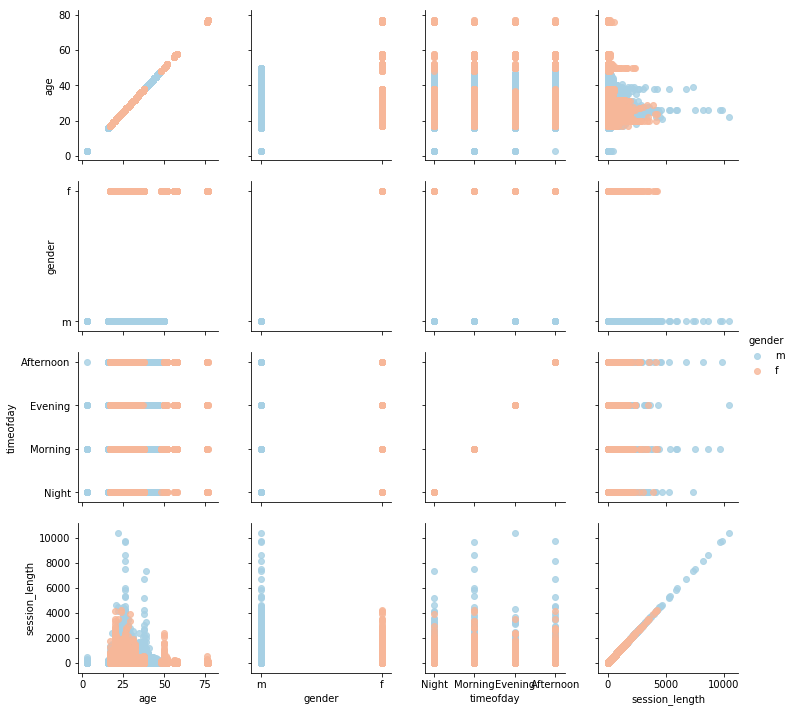

In [265]:
g = sns.PairGrid(plot_df2, vars=['age', 'gender', 'timeofday', 'session_length'],hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

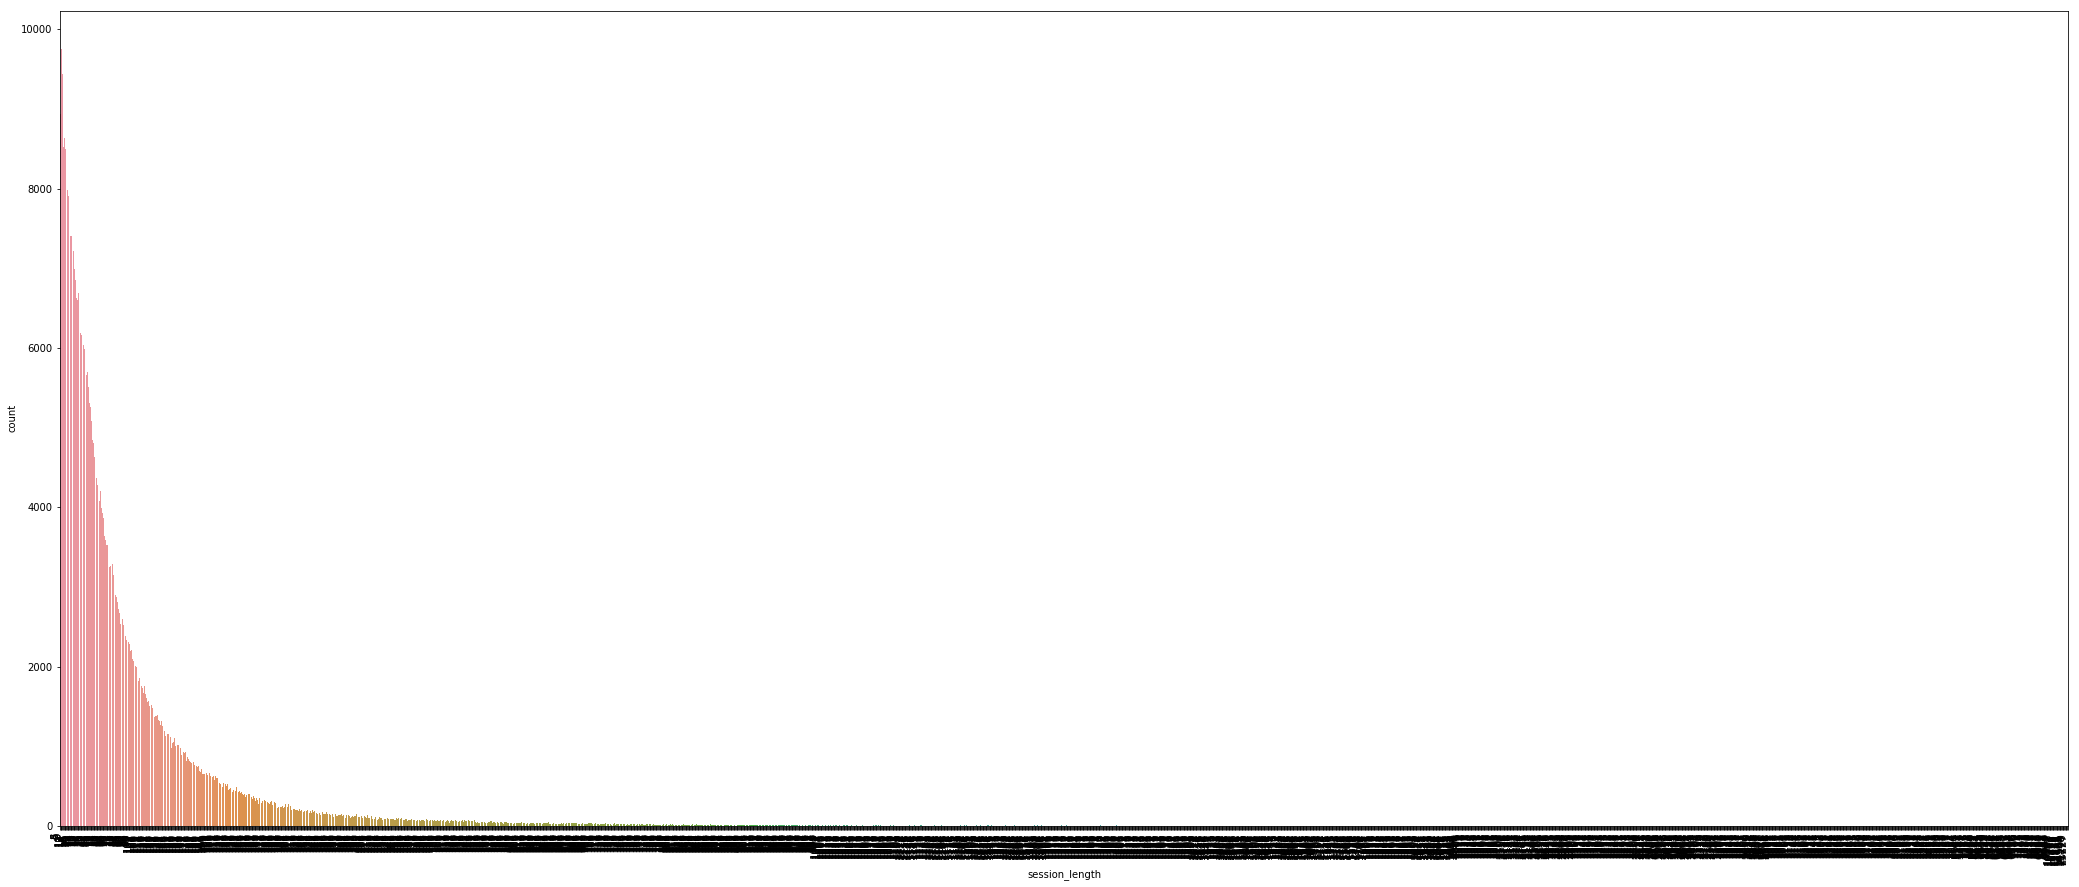

In [266]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 15)
sns.countplot(plot_df['session_length'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

In [267]:
userSession_df = userSession_df.withColumn('log_sess', round(log("session_length"),2)).drop('session_length').withColumnRenamed('log_sess','session_length')

In [277]:
#userSession_df.show(100, False)

In [269]:
#w = Window.partitionBy("userid").orderBy("window").rowsBetween(Window.unboundedPreceding,Window.currentRow)
#(user_session_with_window_df.withColumn("cumSum", sum("session_length").over(w)).show())

In [270]:
plot_log_df = userSession_df.toPandas()

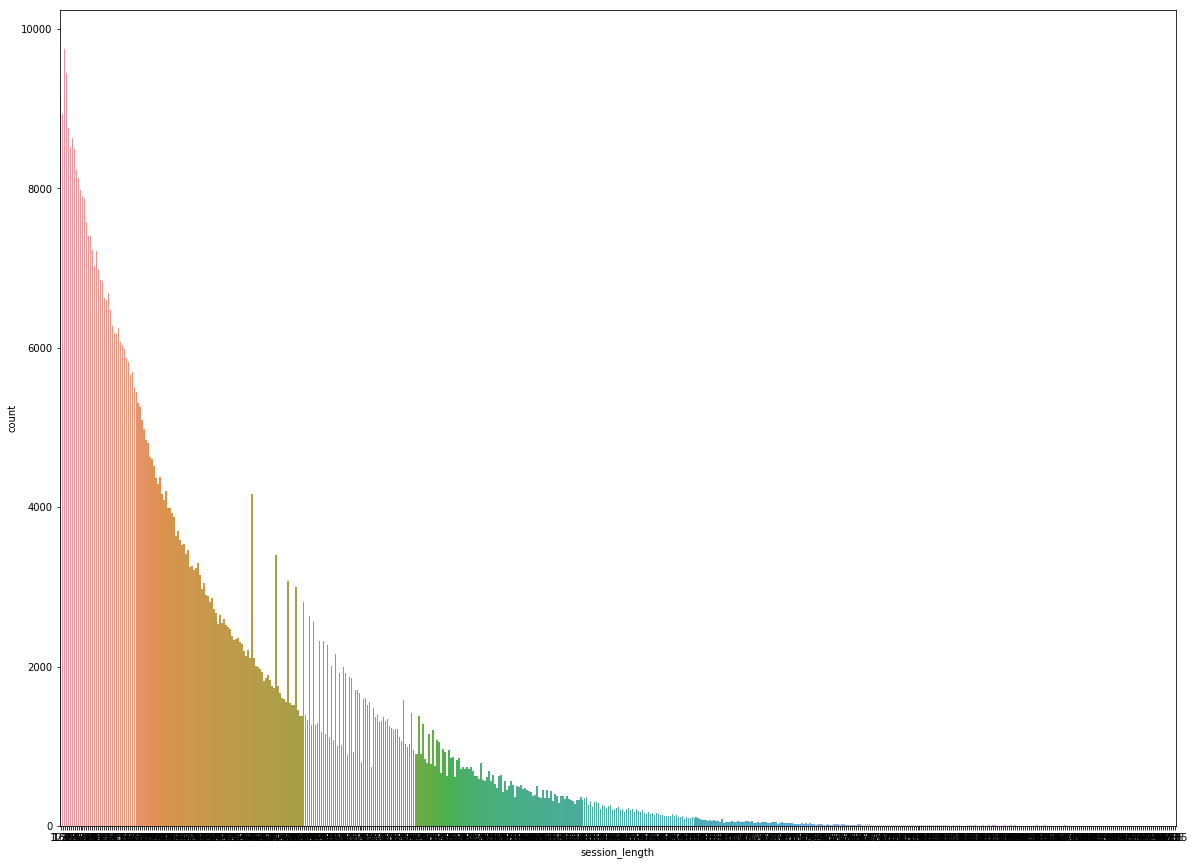

In [271]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
sns.countplot(plot_log_df['session_length'])

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


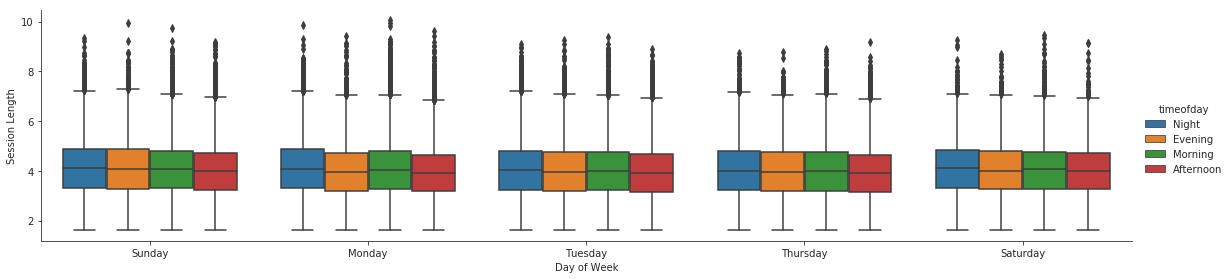

In [272]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("day_of_week", "session_length", "timeofday", data=plot_log_df, kind="box", size=4, aspect=4)
    g.set_axis_labels("Day of Week", "Session Length")

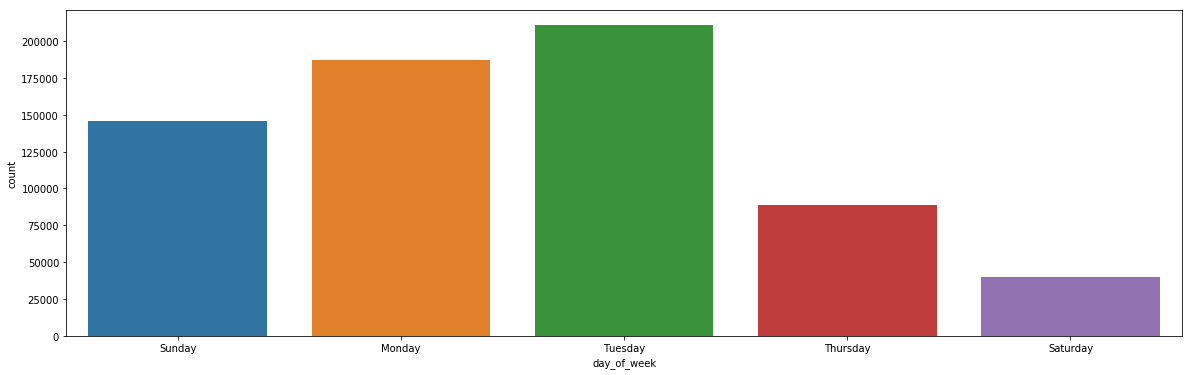

In [273]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.countplot(plot_df['day_of_week'])

In [274]:
sess_tod_df = userSession_df.groupBy('timeofday').agg(count("timeofday").alias("num_sessions"))
sess_tod_df.show()

+---------+------------+
|timeofday|num_sessions|
+---------+------------+
|  Evening|       88029|
|  Morning|      299929|
|Afternoon|      138374|
|    Night|      146279|
+---------+------------+



In [275]:
timeofday    = list([x[0] for x in pd.Series(sess_tod_df.select('timeofday').collect())])
num_sessions = list([y[0] for y in pd.Series(sess_tod_df.select('num_sessions').collect())])

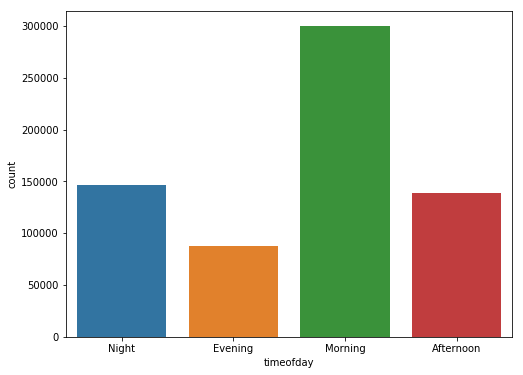

In [276]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.countplot(plot_df['timeofday'])

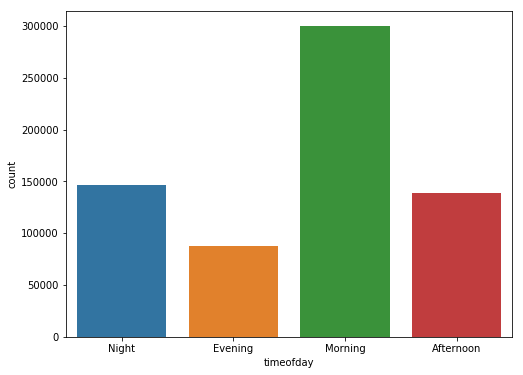

In [277]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.countplot(plot_log_df['timeofday'])

/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


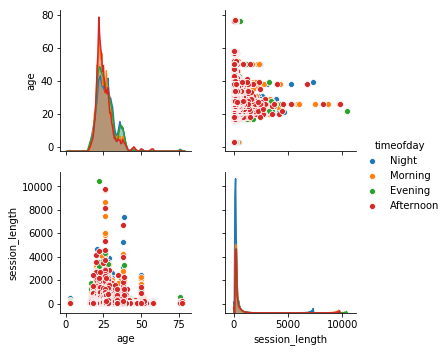

In [278]:

sns.pairplot(plot_df2, hue='timeofday', size=2.5)
plt.show()

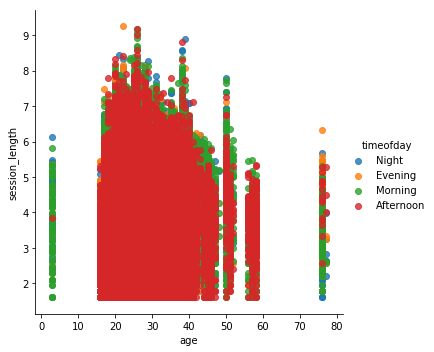

In [279]:
sns.lmplot("age", "session_length", data=plot_log_df, hue='timeofday', fit_reg=False)

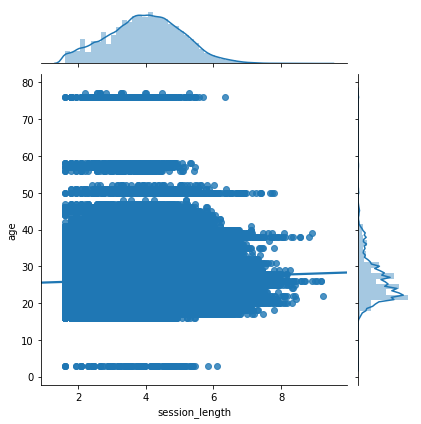

In [280]:
sns.jointplot("session_length", "age", data=plot_log_df, kind='reg');

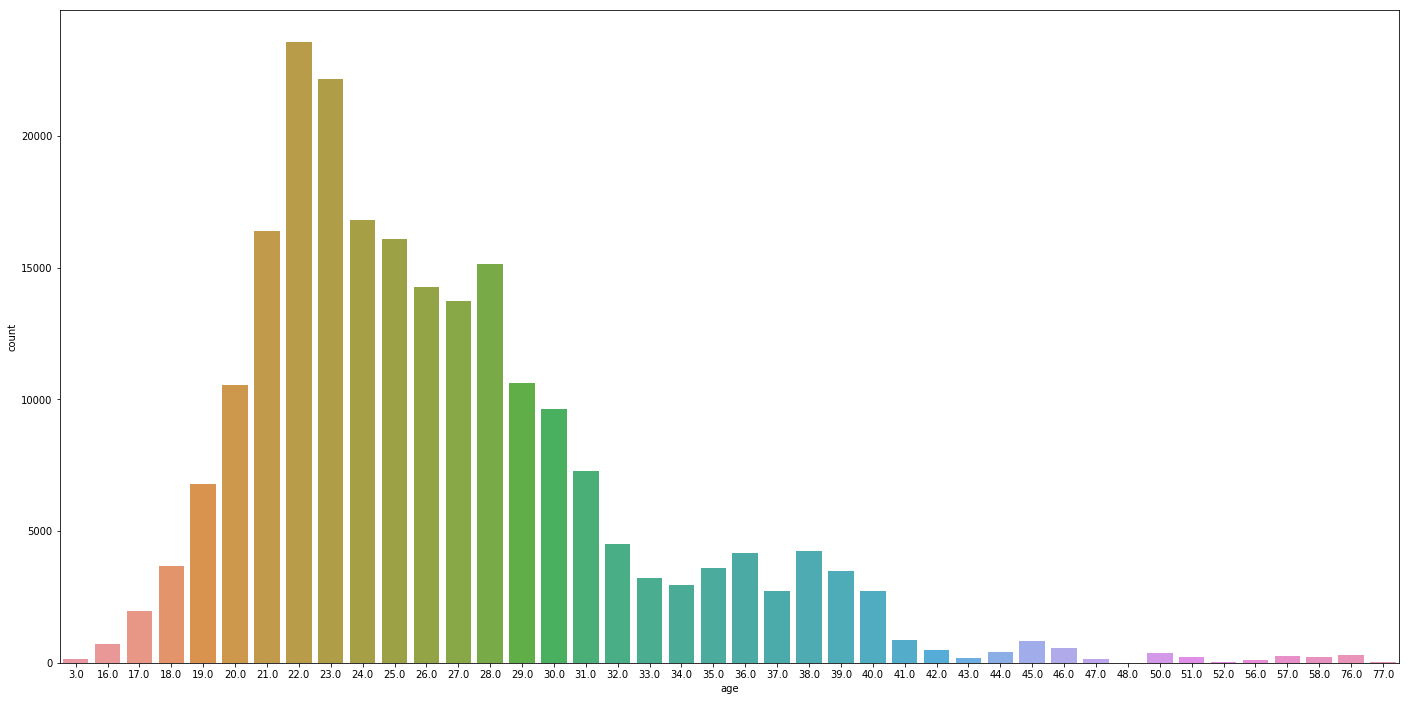

In [281]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 12)
sns.countplot(plot_log_df['age'])

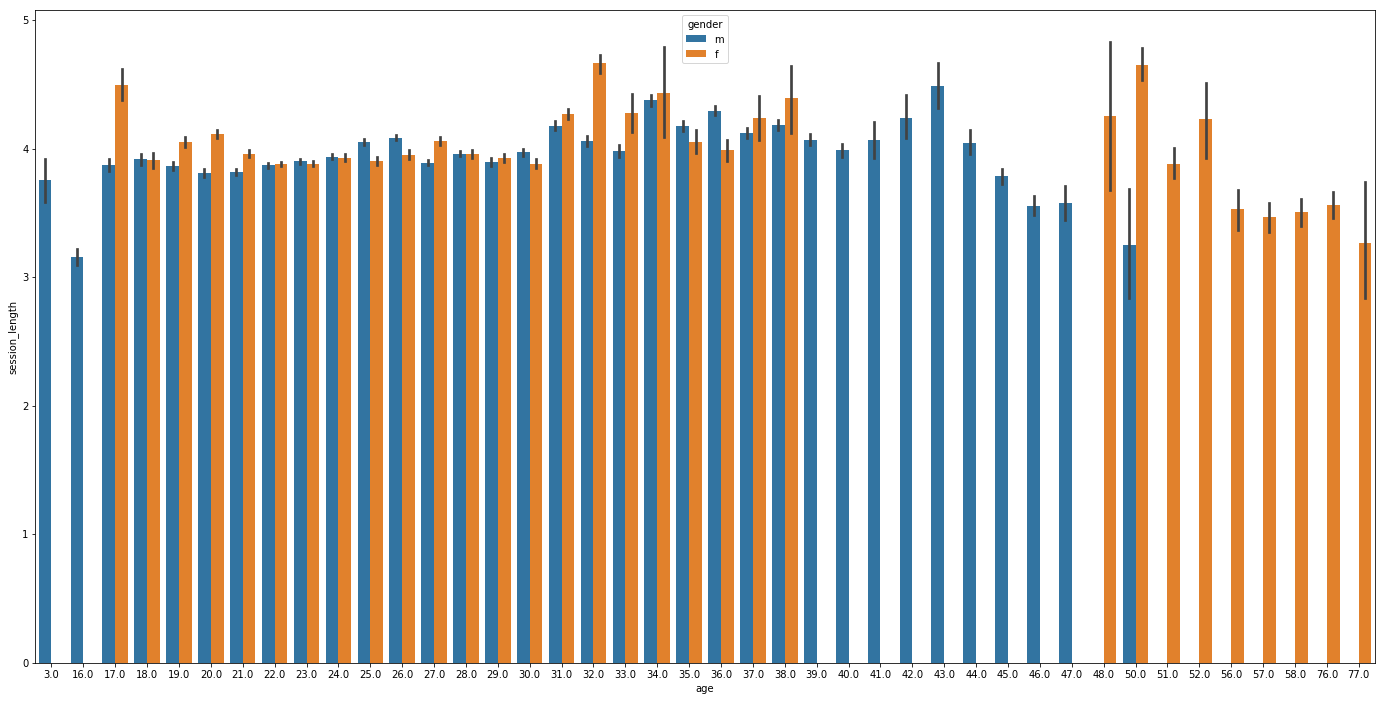

In [282]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 12)
sns.barplot(x="age", y="session_length", hue="gender", data=plot_log_df)

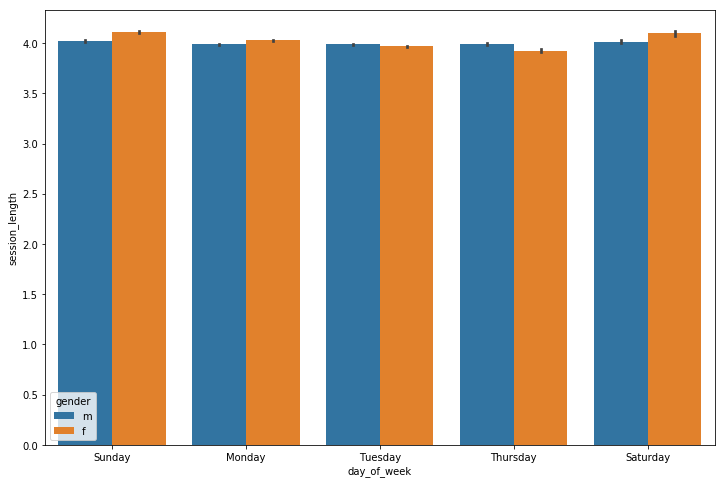

In [283]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.barplot(x="day_of_week", y="session_length", hue="gender", data=plot_log_df)

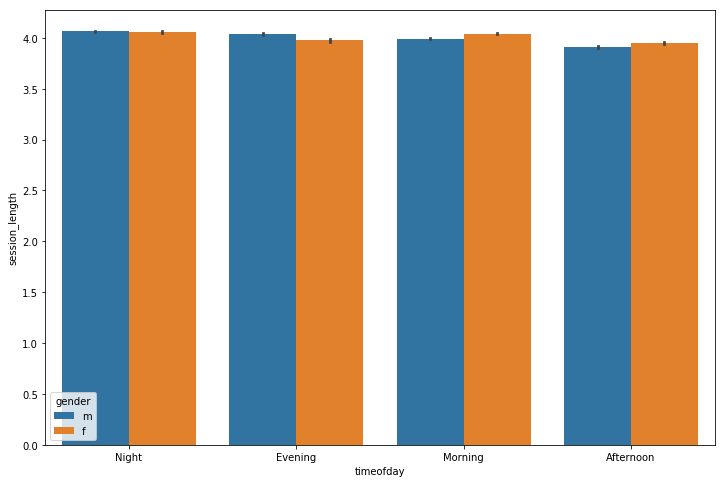

In [284]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.barplot(x="timeofday", y="session_length", hue="gender", data=plot_log_df)

/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


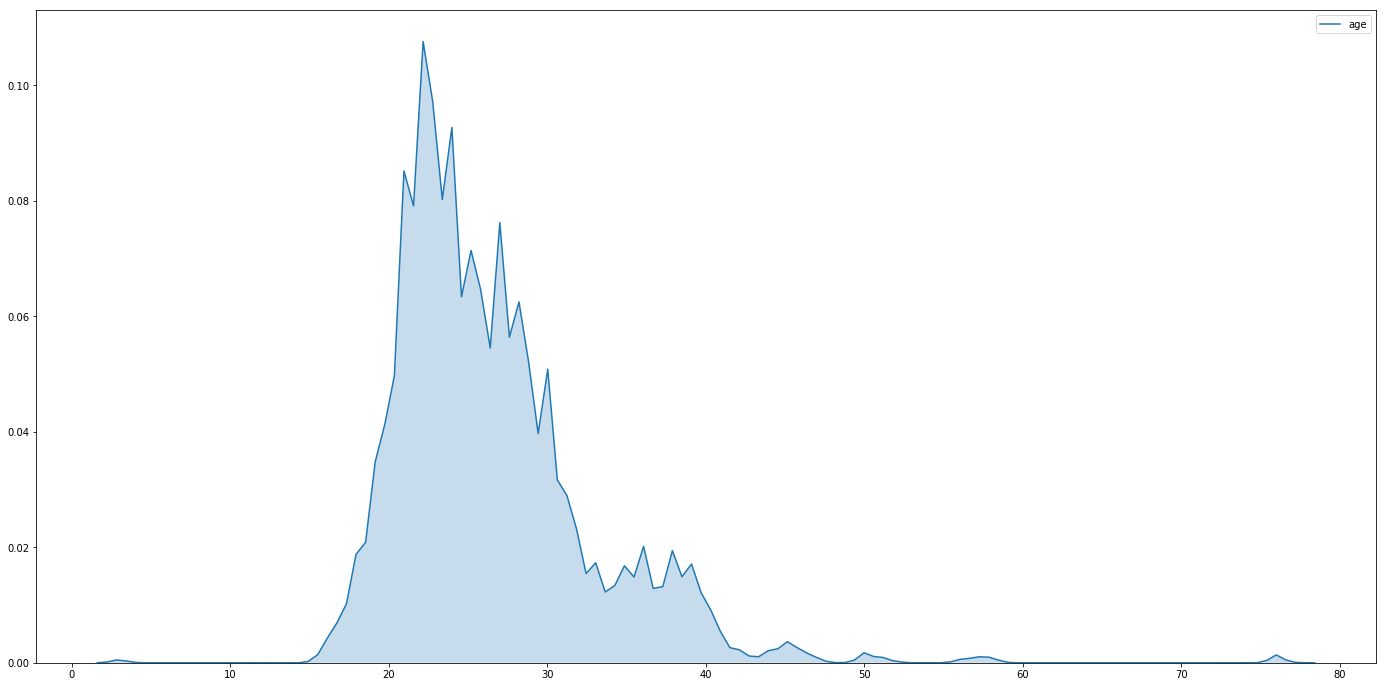

In [285]:
cols = ['age']
fig, ax = plt.subplots()
fig.set_size_inches(24, 12)
for col in cols:
    sns.kdeplot(plot_log_df[col], shade=True)

In [286]:
#sns.kdeplot(plot_log_df.session_length[plot_log_df.gender=='M'], label='men', shade=True)
#sns.kdeplot(plot_log_df.session_length[plot_log_df.gender=='W'], label='women', shade=True)
#plt.xlabel('split_frac');

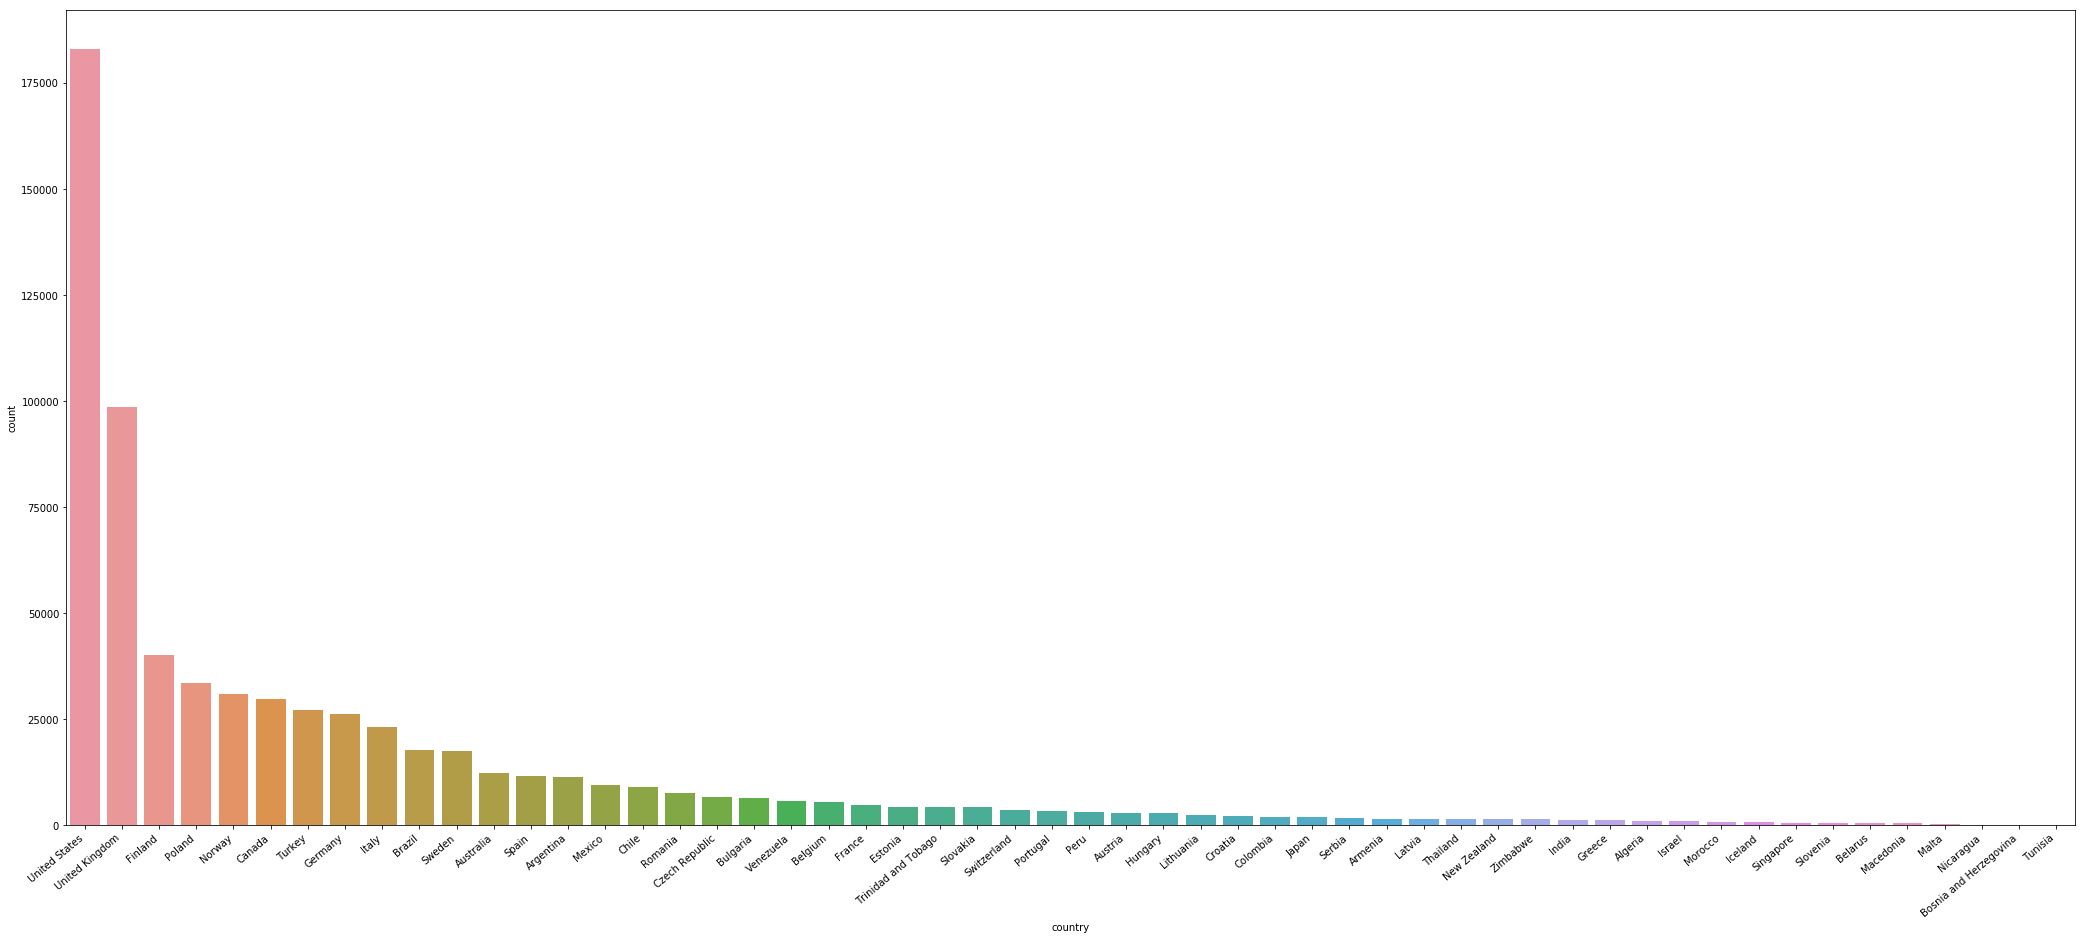

In [287]:
fig, ax = plt.subplots()
fig.set_size_inches(36, 15)
sns.countplot(plot_log_df['country'], order = plot_log_df['country'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

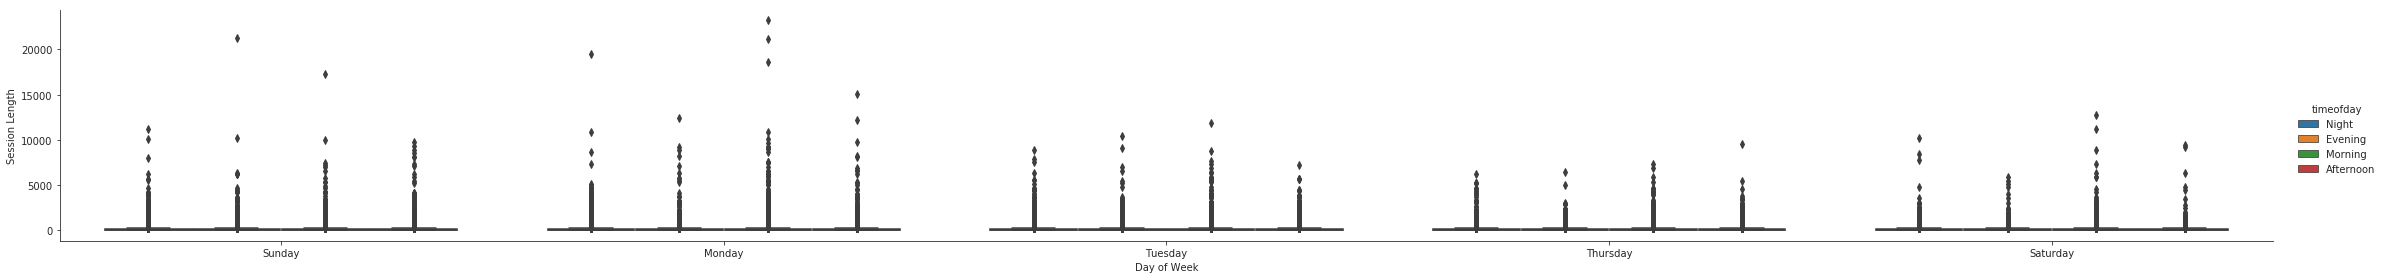

In [288]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("day_of_week", "session_length", "timeofday", data=plot_df, kind="box", size=4, aspect=8)
    g.set_axis_labels("Day of Week", "Session Length")

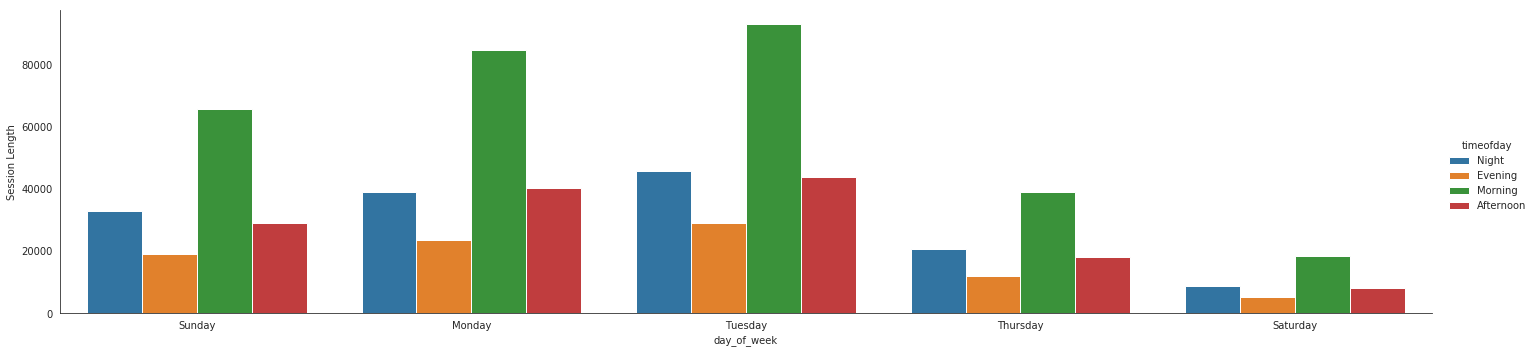

In [289]:
with sns.axes_style('white'):
    g = sns.factorplot("day_of_week", data=plot_log_df, aspect=4.0, kind='count',
                       hue='timeofday')
    g.set_ylabels('Session Length')

In [290]:
data = userSession_df.select('session_length').rdd.map(lambda row: row.session_length).collect()
data[:10]

[5.54, 5.23, 3.89, 4.56, 4.91, 3.93, 4.88, 4.85, 2.94, 3.09]

In [291]:
data = pd.DataFrame(data,columns=['session_length']).iloc[:,0]

In [292]:
data.head(10)

0    5.54
1    5.23
2    3.89
3    4.56
4    4.91
5    3.93
6    4.88
7    4.85
8    2.94
9    3.09
Name: session_length, dtype: float64

In [293]:
data.describe()

count    672611.000000
mean          4.002895
std           1.120782
min           1.610000
25%           3.220000
50%           4.010000
75%           4.770000
max          10.050000
Name: session_length, dtype: float64

In [294]:
deciles = list(np.percentile(data, np.arange(0, 100, 10)))
deciles

[1.61, 2.48, 3.04, 3.4, 3.74, 4.01, 4.3, 4.61, 4.95, 5.42]

#### Add Quantile Bucketized Column

In [295]:
userSession_df.show()

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|                null|           

In [299]:
num_windows = int(userSession_df.select('session_length').distinct().count())
num_windows

560

In [300]:
num_buckets = len(deciles)
num_buckets

10

In [302]:
session_length_bucketizer = QuantileDiscretizer(numBuckets=num_buckets, inputCol="session_length", outputCol="decile", relativeError=0.01, handleInvalid="error")
bucketizer = session_length_bucketizer.fit(userSession_df)
user_session_with_window_bucketized_df = bucketizer.setHandleInvalid("skip").transform(userSession_df)
user_session_with_window_bucketized_df.show()


+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|decile|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|           

In [303]:
user_session_with_window_bucketized_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- genderid: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- country: string (nullable = true)
 |-- startdate: string (nullable = true)
 |-- day_of_week_id: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday_id: integer (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- sessionid: integer (nullable = true)
 |-- session_length_mvavg: double (nullable = true)
 |-- session_length_mvavg_10: double (nullable = true)
 |-- session_length_mvavg_5: double (nullable = true)
 |-- session_length_mvavg_time: double (nullable = true)
 |-- session_start: string (nullable = true)
 |-- previous_duration: double (nullable = true)
 |-- absence_time: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- session_length: double (nullable = true)
 |-- decile: double (nullable = true)



In [304]:
decile_dict = {1.0:"<5_mins",2.0:"<5_mins",3.0:"<10_mins",4.0:"<20_mins",5.0:"<30_mins",6.0:"<40_mins",7.0:"<1_hour",8.0:"<1.5_hours",9.0:"<2_hours",10.0:">3_hours"}

In [305]:
decile_dict

{1.0: '<5_mins',
 2.0: '<5_mins',
 3.0: '<10_mins',
 4.0: '<20_mins',
 5.0: '<30_mins',
 6.0: '<40_mins',
 7.0: '<1_hour',
 8.0: '<1.5_hours',
 9.0: '<2_hours',
 10.0: '>3_hours'}

In [306]:
def get_description(decile):
    try:
        return decile_dict[decile]
    except:
        return None

In [307]:
get_description(1.0)

'<5_mins'

In [308]:
get_desc = udf(lambda bucket: get_description(bucket), returnType=StringType())

In [309]:
user_session_with_window_bucketized_descr_df = user_session_with_window_bucketized_df.withColumn('description', get_desc('decile'))

In [278]:
user_session_with_window_bucketized_descr_df.show(100)

In [311]:
train_data = None
dev_data = None
test_data = None

In [312]:
user_session_with_window_bucketized_descr_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- genderid: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- country: string (nullable = true)
 |-- startdate: string (nullable = true)
 |-- day_of_week_id: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday_id: integer (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- sessionid: integer (nullable = true)
 |-- session_length_mvavg: double (nullable = true)
 |-- session_length_mvavg_10: double (nullable = true)
 |-- session_length_mvavg_5: double (nullable = true)
 |-- session_length_mvavg_time: double (nullable = true)
 |-- session_start: string (nullable = true)
 |-- previous_duration: double (nullable = true)
 |-- absence_time: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- session_length: double (nullable = true)
 |-- decile: double (nullable = true)
 |-- description: string (nullable = true)



In [313]:
from pyspark.sql.functions import percent_rank

def get_train_dev_test_data():
    print("==================================================================================================================")
    print("============================================     CREATE TRAIN/DEV/TEST SETS      =================================")
    print("==================================================================================================================\n\n")
    global train_data, dev_data, test_data
    global user_session_with_window_df
    
    print("SESSION_DATA_WITH_WINDOW_BUCKETIZED_DESCR_DF.USERID.COUNT():\t{}".format(user_session_with_window_bucketized_descr_df.select("userid").distinct().count()))
    session_data = user_session_with_window_bucketized_descr_df.select("userid","gender","age","country", "day_of_week", "timeofday", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","absence_time","is_holiday","session_length","decile").na.drop()
    print("SESSION_DATA.USERID.COUNT():\t{}".format(session_data.select("userid").distinct().count()))
    categoricalColumns = ["userid","gender","country", "day_of_week", "timeofday"]
    cols = session_data.columns
    stages =[]
    for categoricalCol in categoricalColumns:
        stringIndexer  = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"classVec"])
        stages += [stringIndexer,encoder]
    label_stringIdx = StringIndexer(inputCol="decile", outputCol="label")
    stages += [label_stringIdx]
    numericCols = ["is_holiday","session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","absence_time","is_holiday","session_length","decile"]
    assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(session_data)
    session_data = pipelineModel.transform(session_data)
    selectedcols = ["label","features"] + cols
    session_data = session_data.select(selectedcols)
    print("************************************       DATA BEFORE TRAIN/DEV/TEST SPLIT     *************************************")
    #session_data.show(5,False)
    print("************************************           Splitting Train/Test data        *************************************")
    #train_data, dev_data, test_data = session_data.randomSplit([0.65, 0.2, 0.15])
    
    print("SESSION_DATA.COUNT():\t{}".format(session_data.count()))
    print("SESSION_DATA.USERID.COUNT():\t{}".format(session_data.select("userid").distinct().count()))

    session_data_df = session_data.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("userid")))
    train_data = session_data_df.where("rank <= .65").drop("rank")
    #train_data.show()
    dev_data = session_data_df.where(("rank > .65") and ("rank < 0.799")).drop("rank")
    #dev_data.show()
    test_data = session_data_df.where("rank > .80").drop("rank")
    #test_data.show()

In [314]:
get_train_dev_test_data()

============================================     CREATE TRAIN/DEV/TEST SETS      =================================


SESSION_DATA_WITH_WINDOW_BUCKETIZED_DESCR_DF.USERID.COUNT():	845
SESSION_DATA.USERID.COUNT():	250
************************************       DATA BEFORE TRAIN/DEV/TEST SPLIT     *************************************
************************************           Splitting Train/Test data        *************************************
SESSION_DATA.COUNT():	202239
SESSION_DATA.USERID.COUNT():	250


In [315]:
train_data.show(5,False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------------+-----------+---------+--------------------+-----------------------+----------------------+-------------------------+-----------------+------------+----------+--------------+------+
|label|features                                                                                                                                        |userid     |gender|age |country      |day_of_week|timeofday|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|previous_duration|absence_time|is_holiday|session_length|decile|
+-----+------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------------+-----------+---------+--------------------+-----------------------+-

In [316]:
dev_data.show(5,False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------------+-----------+---------+--------------------+-----------------------+----------------------+-------------------------+-----------------+------------+----------+--------------+------+
|label|features                                                                                                                                        |userid     |gender|age |country      |day_of_week|timeofday|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|previous_duration|absence_time|is_holiday|session_length|decile|
+-----+------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------------+-----------+---------+--------------------+-----------------------+-

In [317]:
test_data.show(5,False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------------+-----------+---------+--------------------+-----------------------+----------------------+-------------------------+-----------------+------------+----------+--------------+------+
|label|features                                                                                                                                 |userid     |gender|age |country      |day_of_week|timeofday|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|previous_duration|absence_time|is_holiday|session_length|decile|
+-----+-----------------------------------------------------------------------------------------------------------------------------------------+-----------+------+----+-------------+-----------+---------+--------------------+-----------------------+----------------------

### BASELINE DL model with Multinomial Naive Bayes

In [318]:
smoothings  = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [319]:
mnbModel = None

In [320]:
def mnb_classifier(smoothing):
    global mnbModel
    global lr_results
    global train_data, dev_data, test_data
    mnb = NaiveBayes(smoothing=smoothing, modelType="multinomial")
    #print("---------------------------------  Fitting Model to TRAIN  ---------------------------")
    mnbModel = mnb.fit(train_data)
    #print("---------------------------------  Generating Predictions  ---------------------------")
    predictions = mnbModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "gender","is_holiday","country", "day_of_week", "timeofday", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","absence_time","session_length")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    #print("---------------------------------  Evaluating Model     ------------------------------")
    result = evaluator.evaluate(mnbModel.transform(dev_data))
    #result.select("features","label","prediction").show(5,False)
    mnb_results.update({smoothing:result})


In [321]:
def eval_mnb_classifier():
    print("###########################################################################################")
    print("############################     MULTINOMIAL NAIVE BAYES CLASSIFIER      ##################")
    print("###########################################################################################")
    print("\tSMOOTHING\tACCURACY")
    for smoothing in smoothings:
        mnb_classifier(smoothing)
        print("\t{}\t\t{}".format(smoothing, mnb_results[smoothing]))
        

In [322]:
mnb_results = dict()

eval_mnb_classifier()

###########################################################################################
############################     MULTINOMIAL NAIVE BAYES CLASSIFIER      ##################
###########################################################################################
	SMOOTHING	ACCURACY
	0.1		0.108364611588
	0.2		0.108205413944
	0.3		0.108144184081
	0.4		0.108095200191
	0.5		0.108027847342
	0.6		0.10799723241
	0.7		0.10799723241
	0.8		0.107978863451
	0.9		0.107954371506
	1.0		0.107936002547


### BASELINE DL model with Multinomial Logistic Regression

In [323]:
lrModel = None

In [328]:
def logistic_classifier(regparam, elasticnetparam):
    global lrModel
    global lr_results
    global train_data, dev_data, test_data
    lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=regparam, elasticNetParam=elasticnetparam)
    #print("---------------------------------  Fitting Model to TRAIN  ---------------------------")
    lrModel = lr.fit(train_data)
    #print("---------------------------------  Generating Predictions  ---------------------------")
    predictions = lrModel.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "gender", "country", "day_of_week", "timeofday", "is_holiday", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","absence_time","is_holiday")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    #print("---------------------------------  Evaluating Model     ------------------------------")
    result = evaluator.evaluate(lrModel.transform(dev_data))
    #result.select("features","label","prediction").show(5,False)
    lr_results.update({elasticnetparam:{regparam:result}})
    #print("MULTINOMIAL LOGISTIC REGRESSION RESULTS:\t{}".format(lr_results))

In [329]:
regparams        = [0.00000001,0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
elasticnetparams = [0.00000001,0.0000001,  0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

In [330]:
def eval_mlr_classifier():
    print("###########################################################################################")
    print("###############################         LOGISTIC REGRESSION         #######################")
    print("###########################################################################################")
    print("\tREGPARAM\tELASTICNETPARAM\t\tACCURACY")
    for regparam in regparams:
        for elasticnetparam in elasticnetparams:
            logistic_classifier(regparam, elasticnetparam)
            print("\t{}\t\t\t{}\t\t{}".format(regparam, elasticnetparam,lr_results))
        

In [331]:
lr_results = {}
eval_mlr_classifier()

###########################################################################################
###############################         LOGISTIC REGRESSION         #######################
###########################################################################################
	REGPARAM	ELASTICNETPARAM		ACCURACY
	1e-08			1e-08		{1e-08: {1e-08: 0.43719346799821207}}
	1e-08			1e-07		{1e-08: {1e-08: 0.43719346799821207}, 1e-07: {1e-08: 0.43719346799821207}}
	1e-08			1e-06		{1e-08: {1e-08: 0.43719346799821207}, 1e-07: {1e-08: 0.43719346799821207}, 1e-06: {1e-08: 0.43719346799821207}}
	1e-08			1e-05		{1e-08: {1e-08: 0.43719346799821207}, 1e-07: {1e-08: 0.43719346799821207}, 1e-05: {1e-08: 0.43719346799821207}, 1e-06: {1e-08: 0.43719346799821207}}
	1e-08			0.0001		{1e-08: {1e-08: 0.43719346799821207}, 1e-07: {1e-08: 0.43719346799821207}, 1e-05: {1e-08: 0.43719346799821207}, 0.0001: {1e-08: 0.43719346799821207}, 1e-06: {1e-08: 0.43719346799821207}}
	1e-08			0.001		{1e-06: {1e-08: 0.437193467998

	1e-05			0.001		{1e-06: {1e-05: 0.43716285306669767}, 1e-05: {1e-05: 0.43716285306669767}, 0.1: {1e-06: 0.43719346799821207}, 1e-08: {1e-05: 0.43716285306669767}, 1e-07: {1e-05: 0.43716285306669767}, 0.001: {1e-05: 0.43716285306669767}, 0.0001: {1e-05: 0.43716285306669767}, 0.01: {1e-06: 0.43719346799821207}}
	1e-05			0.01		{1e-06: {1e-05: 0.43716285306669767}, 1e-05: {1e-05: 0.43716285306669767}, 0.1: {1e-06: 0.43719346799821207}, 1e-08: {1e-05: 0.43716285306669767}, 1e-07: {1e-05: 0.43716285306669767}, 0.001: {1e-05: 0.43716285306669767}, 0.0001: {1e-05: 0.43716285306669767}, 0.01: {1e-05: 0.4371567300803948}}
	1e-05			0.1		{1e-06: {1e-05: 0.43716285306669767}, 1e-05: {1e-05: 0.43716285306669767}, 0.1: {1e-05: 0.43187259290100966}, 1e-08: {1e-05: 0.43716285306669767}, 1e-07: {1e-05: 0.43716285306669767}, 0.001: {1e-05: 0.43716285306669767}, 0.0001: {1e-05: 0.43716285306669767}, 0.01: {1e-05: 0.4371567300803948}}
	0.0001			1e-08		{1e-06: {1e-05: 0.43716285306669767}, 1e-05: {1e-05: 0.

	0.1			1e-08		{1e-06: {0.01: 0.39937178160532455}, 1e-05: {0.01: 0.4070744983743471}, 0.1: {0.01: 0.4213716713915711}, 1e-08: {0.1: 0.33748675904212}, 1e-07: {0.01: 0.39937178160532455}, 0.001: {0.01: 0.4020597725922887}, 0.0001: {0.01: 0.39435705582326613}, 0.01: {0.01: 0.4257924675022502}}
	0.1			1e-07		{1e-06: {0.01: 0.39937178160532455}, 1e-05: {0.01: 0.4070744983743471}, 0.1: {0.01: 0.4213716713915711}, 1e-08: {0.1: 0.33748675904212}, 1e-07: {0.1: 0.33748675904212}, 0.001: {0.01: 0.4020597725922887}, 0.0001: {0.01: 0.39435705582326613}, 0.01: {0.01: 0.4257924675022502}}
	0.1			1e-06		{1e-06: {0.1: 0.33507430243878544}, 1e-05: {0.01: 0.4070744983743471}, 0.1: {0.01: 0.4213716713915711}, 1e-08: {0.1: 0.33748675904212}, 1e-07: {0.1: 0.33748675904212}, 0.001: {0.01: 0.4020597725922887}, 0.0001: {0.01: 0.39435705582326613}, 0.01: {0.01: 0.4257924675022502}}
	0.1			1e-05		{1e-06: {0.1: 0.33507430243878544}, 1e-05: {0.1: 0.32658172043669137}, 0.1: {0.01: 0.4213716713915711}, 1e-08: {0.1:

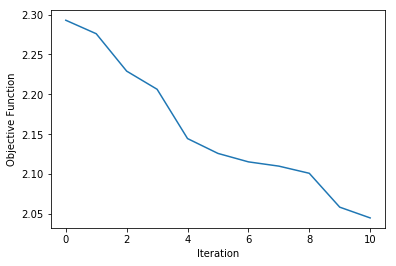

In [332]:
trainingSummary = lrModel.summary

objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

In [333]:
predictions = lrModel.transform(dev_data)
predictions.select("features","label","prediction").show(10, False)

+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|features                                                                                                                                        |label|prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|(304,[62,249,250,293,294,295,296,297,298,299,300,301,302,303],[1.0,1.0,1.0,1.0,1.0,6706.67,6706.67,6706.67,4134.0,10704.0,15219.0,1.0,4.73,7.0])|1.0  |1.0       |
|(304,[62,249,250,291,294,295,296,297,298,299,300,301,302,303],[1.0,1.0,1.0,1.0,1.0,6725.5,6725.5,6725.5,10704.0,6782.0,15748.0,1.0,5.57,9.0])   |9.0  |1.0       |
|(304,[62,249,250,291,294,295,296,297,298,299,300,301,302,303],[1.0,1.0,1.0,1.0,1.0,8537.2,8537.2,8537.2,5282.0,15784.0,91993.0,1.0,3.37,2.0])   |8.0  |0.0       |
|(304,[62,249,25

In [334]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.730601


In [335]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [336]:
predictions.select('userid','gender','age','timeofday','absence_time','is_holiday','session_length', 'decile','prediction').sample(0.001,100).show(30, False)

+-----------+------+----+---------+------------+----------+--------------+------+----------+
|userid     |gender|age |timeofday|absence_time|is_holiday|session_length|decile|prediction|
+-----------+------+----+---------+------------+----------+--------------+------+----------+
|user_000003|m     |23.0|Night    |4075.0      |1         |3.91          |4.0   |0.0       |
|user_000009|f     |21.0|Night    |47085.0     |1         |3.22          |2.0   |0.0       |
|user_000012|f     |28.0|Morning  |3264.0      |0         |5.18          |8.0   |1.0       |
|user_000012|f     |30.0|Evening  |51433.0     |0         |4.64          |7.0   |1.0       |
|user_000012|f     |30.0|Morning  |9405.0      |0         |3.69          |3.0   |0.0       |
|user_000013|f     |25.0|Morning  |45352.0     |0         |5.84          |9.0   |1.0       |
|user_000017|m     |23.0|Afternoon|2927.0      |0         |4.83          |7.0   |1.0       |
|user_000021|m     |27.0|Evening  |35229.0     |0         |2.94       

In [337]:
class_temp  = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp

,label,count
0,0.0,20119
1,1.0,18744
2,2.0,18057
3,3.0,16746
4,4.0,16113
5,5.0,16030
6,7.0,15347
7,6.0,15199
8,8.0,15157
9,9.0,11807


In [338]:
class_names = class_temp['label']

In [339]:
class_names

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
6    7.0
7    6.0
8    8.0
9    9.0
Name: label, dtype: float64

### Manually Create Confusion Matrix

In [340]:
df = predictions.select('label','prediction')
df.show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  9.0|       1.0|
|  8.0|       0.0|
|  2.0|       0.0|
|  8.0|       0.0|
|  5.0|       1.0|
|  0.0|       0.0|
|  8.0|       0.0|
|  9.0|       1.0|
|  8.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  4.0|       1.0|
|  4.0|       1.0|
|  7.0|       0.0|
|  2.0|       0.0|
|  4.0|       1.0|
|  3.0|       1.0|
|  7.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [341]:
print("\tLABEL\tLabels\tPredictions")
for label in class_names:
    num_labels = df[df['label'] == label].count()
    num_correct_preds = df[(df['label'] == label) & (df['prediction'] == label)].count()
    print("\t{}\t{}\t{}".format(label,num_labels,num_correct_preds))

	LABEL	Labels	Predictions
	0.0	20119	20118
	1.0	18744	18307
	2.0	18057	3124
	3.0	16746	0
	4.0	16113	0
	5.0	16030	346
	7.0	15347	0
	6.0	15199	0
	8.0	15157	0
	9.0	11807	2103


In [342]:
predictions_rdd = predictions.select('prediction','label').rdd.map(tuple)

In [343]:
predictions_rdd.take(5)

[(1.0, 1.0), (1.0, 9.0), (0.0, 8.0), (0.0, 2.0), (0.0, 8.0)]

In [344]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics



In [345]:
metrics = MulticlassMetrics(predictions_rdd.map(tuple))

In [346]:


# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = \t\t%s" % precision)
print("Recall = \t\t%s" % recall)
print("F1 Score = \t\t%s" % f1Score)

# Statistics by class
#labels = data.map(lambda lp: lp.label).distinct().collect()
labels = class_names
for label in sorted(labels):
    print("Class %s precision = \t%s" % (label, metrics.precision(label)))
    print("Class %s recall = \t%s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = \t%s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("Weighted recall = \t%s" % metrics.weightedRecall)
print("Weighted precision = \t%s" % metrics.weightedPrecision)
print("Weighted F(1) Score = \t%s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 		0.269399151354
Recall = 		0.269399151354
F1 Score = 		0.269399151354
Class 0.0 precision = 	0.293689143224
Class 0.0 recall = 	0.99995029574
Class 0.0 F1 Measure = 	0.454028436019
Class 1.0 precision = 	0.208460487361
Class 1.0 recall = 	0.976685872813
Class 1.0 F1 Measure = 	0.343586952442
Class 2.0 precision = 	0.990488268865
Class 2.0 recall = 	0.173007697846
Class 2.0 F1 Measure = 	0.294564141247
Class 3.0 precision = 	0.0
Class 3.0 recall = 	0.0
Class 3.0 F1 Measure = 	0.0
Class 4.0 precision = 	0.0
Class 4.0 recall = 	0.0
Class 4.0 F1 Measure = 	0.0
Class 5.0 precision = 	0.500723589001
Class 5.0 recall = 	0.0215845290081
Class 5.0 F1 Measure = 	0.0413850846241
Class 6.0 precision = 	0.0
Class 6.0 recall = 	0.0
Class 6.0 F1 Measure = 	0.0
Class 7.0 precision = 	0.0
Class 7.0 recall = 	0.0
Class 7.0 F1 Measure = 	0.0
Class 8.0 precision = 	0.0
Class 8.0 recall = 	0.0
Class 8.0 F1 Measure = 	0.0
Class 9.0 precision = 	0.667195431472
Class 9.0 recall = 	0

In [347]:
m = metrics.confusionMatrix()

In [348]:
from pyspark.mllib.linalg import Vectors, DenseMatrix 

import seaborn as sns
sns.set() 


def display_cm(m):
  a = m.toArray().astype(np.float)
  row_sums = a.sum(axis=1)
  percentage_matrix = a.astype(np.float) / row_sums[:, np.newaxis]
  print(percentage_matrix)
  plt.figure(figsize=(3, 3))
  sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=['0' ,'1','2'], yticklabels=['0' ,'1','2']);
  plt.title('Confusion Matrix');

[[9.99950296e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.97042597e-05]
 [0.00000000e+00 9.76685873e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.94921041e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.53649168e-02]
 [8.25053996e-01 1.66140555e-04 1.73007698e-01 0.00000000e+00
  0.00000000e+00 1.21836407e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.53801850e-04]
 [1.75922608e-01 8.17389227e-01 2.98578765e-04 0.00000000e+00
  0.00000000e+00 4.47868148e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.91090410e-03]
 [4.09607150e-03 9.84236331e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.40637994e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.26121765e-03]
 [0.00000000e+00 9.67186525e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.15845290e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.12289457e-02]
 [0.00000000e+00 9.70787552e-01 0.00000000e+00 0.00000000e

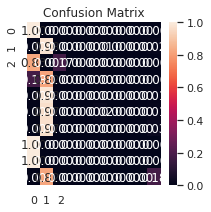

In [349]:
display_cm(m)

### BASELINE DL model with an generic MLP Classifier

In [363]:
train_data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userid: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- country: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- session_length_mvavg: double (nullable = true)
 |-- session_length_mvavg_10: double (nullable = true)
 |-- session_length_mvavg_5: double (nullable = true)
 |-- session_length_mvavg_time: double (nullable = true)
 |-- previous_duration: double (nullable = true)
 |-- absence_time: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- session_length: double (nullable = true)
 |-- decile: double (nullable = true)



In [364]:
def mlp_classifier():
    print("###########################################################################################")
    print("##################################       MLP CLASSIFIER      ##############################")
    print("###########################################################################################")
    global mlp_results
    global train_data, dev_data, test_data
    layer_1 = train_data.schema["features"].metadata["ml_attr"]["num_attrs"]
    layer_2 = layer_1*4
    layer_3 = int(layer_2/2)
    layer_4 = num_buckets
    layers = [layer_1, layer_2, layer_3, layer_4]
    print("LAYERS: \t{}".format(layers))
    print("---------------------------------  Training MLP Model        ------------------------------")
    trainer = MultilayerPerceptronClassifier(maxIter=5, layers=layers, blockSize=128)
    print("---------------------------------  Fitting Model to TRAIN    ------------------------------")
    mlp_model = trainer.fit (train_data)        
    print("---------------------------------  Testing Model against DEV ------------------------------")
    predictions = mlp_model.transform(dev_data)
    selected = predictions.select("label", "prediction", "userid", "gender","country", "day_of_week", "timeofday", "is_holiday","session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","absence_time","is_holiday","session_length")
    print("evaluator = MulticlassClassificationEvaluator().....")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol("prediction")
    print("result = evaluator.evaluate(mlp_model.transform(dev_data))")
    result = evaluator.evaluate(mlp_model.transform(dev_data))
    mlp_results.append(result)
    print("MLP CLASSIFIER RESULTS:\t{}".format(mlp_results))

In [365]:
#mlp_results = []
#mlp_classifier()

### BASELINE Model with Decision Tree Classifier

In [366]:
dt_results = dict()
maxBins = 100


In [367]:
def decisionTree_classifier(max_depth):
    global dt_results
    global train_data, dev_data, test_data
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=max_depth, maxBins=100)
    dtModel = dt.fit(train_data)
    #print("numNodes = ", dtModel.numNodes)
    #print("depth = ", dtModel.depth)
    evaluator = MulticlassClassificationEvaluator().setMetricName ('accuracy').setPredictionCol ('prediction').setLabelCol ('label')
    #print("result = evaluator.evaluate(dfModel.transform(dev_data))")
    result = evaluator.evaluate(dtModel.transform(dev_data))
    #print("dt_results.append(result)")
    dt_results.update({max_depth:result})
    #print("DECISION TREE CLASSIFIER RESULTS:\t{}".format(dt_results))

In [369]:
def eval_dt_classifier():
    print("###########################################################################################")
    print("###############################          DECISION TREE              #######################")
    print("###########################################################################################")
    print("\tNUM_TREES\tMAX_TREE_DEPTH\t\tACCURACY")
    global dt_results
    for max_tree_depth in max_tree_depths:
        decisionTree_classifier(max_tree_depth)
        print("\t\t\t\t{}\t\t{}".format(max_tree_depth,dt_results[max_tree_depth]))
        

In [370]:
max_tree_depths = [1,2,3,4,5,6,7,8,9,10]

In [371]:
dt_results = dict()
eval_dt_classifier()

###########################################################################################
###############################          DECISION TREE              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY
				1		0.237957616689
				2		0.34852038036
				3		0.545025379778
				4		0.736491161469
				5		0.834642631904
				6		0.927705900722
				7		1.0
				8		1.0
				9		1.0
				10		1.0


### BASELINE Model with RandomForest Classifier

In [372]:
rfModel = None
def randomForest_classifier(num_tree, max_tree_depth):
    global rf_results
    global rfModel
    global train_data, dev_data, test_data
    #rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=20, maxBins=100)
    rf = RandomForestClassifier(numTrees=num_tree, featureSubsetStrategy="auto", impurity="gini", labelCol="label", featuresCol="features", maxDepth=max_tree_depth, maxBins=100)
    
    #print("---------------------------------  Fitting Model to Train     ------------------------------")
    rfModel = rf.fit(train_data)
    #print("---------------------------------  Transforming Dev           ------------------------------")
    predictions = rfModel.transform(dev_data)
    selected = predictions.select("label", "gender", "prediction", "userid", "country", "day_of_week", "timeofday", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","absence_time","is_holiday","session_length")
    #print("---------------------------------     Evaluating Model        ------------------------------")
    evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setPredictionCol ('prediction').setLabelCol ('label')
    result = evaluator.evaluate(rfModel.transform(dev_data))
    #print("---------------------------------  Summarizing Results        ------------------------------")
    rf_results.update({num_tree:{max_tree_depth:result}})
    #print("RANDOM FOREST CLASSIFIER RESULTS:\t{}".format(rf_results))

In [373]:
def eval_rf_classifier():
    print("###########################################################################################")
    print("###############################          RANDOM FOREST              #######################")
    print("###########################################################################################")
    print("\tNUM_TREES\tMAX_TREE_DEPTH\t\tACCURACY")
    for num_tree in num_trees:
        for max_tree_depth in max_tree_depths:
            randomForest_classifier(num_tree, max_tree_depth)
            print("\t{}\t\t\t{}\t\t{}".format(num_tree, max_tree_depth,rf_results))
        

In [374]:
max_tree_depths = [20, 25, 30]
num_trees       = [30,40,50,60,70]

In [375]:
rf_results = dict()

eval_rf_classifier()

###########################################################################################
###############################          RANDOM FOREST              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY
	30			20		{30: {20: 0.9331737274903716}}
	30			25		{30: {25: 0.9655398330873933}}
	30			30		{30: {30: 0.979041017885243}}
	40			20		{40: {20: 0.9698687844035293}, 30: {30: 0.979041017885243}}
	40			25		{40: {25: 0.9766469302408171}, 30: {30: 0.979041017885243}}
	40			30		{40: {30: 0.985298709886786}, 30: {30: 0.979041017885243}}
	50			20		{40: {30: 0.985298709886786}, 50: {20: 0.9600536373600133}, 30: {30: 0.979041017885243}}
	50			25		{40: {30: 0.985298709886786}, 50: {25: 0.9742283506511796}, 30: {30: 0.979041017885243}}
	50			30		{40: {30: 0.985298709886786}, 50: {30: 0.9818943295023849}, 30: {30: 0.979041017885243}}
	60			20		{40: {30: 0.985298709886786}, 50: {30: 0.981894329

In [376]:
max_tree_depths = [20,25,30]
num_trees       = [20,25,30,35,40,45,50]

In [377]:
rf_results = dict()

eval_rf_classifier()

###########################################################################################
###############################          RANDOM FOREST              #######################
###########################################################################################
	NUM_TREES	MAX_TREE_DEPTH		ACCURACY
	20			20		{20: {20: 0.9311531420104213}}
	20			25		{20: {25: 0.9574942290854095}}
	20			30		{20: {30: 0.9730098763769065}}
	25			20		{25: {20: 0.9437236328902332}, 20: {30: 0.9730098763769065}}
	25			25		{25: {25: 0.9709647989517447}, 20: {30: 0.9730098763769065}}
	25			30		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}}
	30			20		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}, 30: {20: 0.9331737274903716}}
	30			25		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}, 30: {25: 0.9655398330873933}}
	30			30		{25: {30: 0.9843618929824454}, 20: {30: 0.9730098763769065}, 30: {30: 0.979041017885243}}
	35			20		{25: {30: 0.9843618929824454}, 35: {20: 

### SCIKIT LEARN

In [378]:
# Import SciKitLearn
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, MultiTaskLassoCV, LassoLarsCV, LassoLarsIC 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV as CV

# Other packages
import time
import numpy as np
import pandas as pd
import re
import scipy as sp
import matplotlib.pyplot as plt
from numpy import concatenate
from pandas import DataFrame, Series, read_csv, scatter_matrix

# Install packages
!pip install keras

# Weighted Mean Absolute Error Function
def weighted_mean_abs_err(y_true, y_pred, weights):
  return np.mean(np.mean(np.abs(y_true - y_pred), axis=1) * weights)

/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [379]:
#!head /data_data/session_length/usersessions-with-ids-jayashree.csv

In [380]:
user_session_with_window_bucketized_descr_df.show(5)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+------+-----------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|decile|description|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+------+-----------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|        

In [381]:
userSession_df.show(5,False)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|userid     |genderid|gender|age |country|startdate |day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|session_start      |previous_duration|absence_time|is_holiday|session_length|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+
|user_000001|1.0     |m     |null|Japan  |2006-08-14|0             |Sunday     |4           |Night    |1        |null                |null       

In [382]:
int("user_000055".split("_")[1].lstrip("0"))

55

In [383]:
def get_user_num(userid):
    return int(userid.split("_")[1].lstrip("0"))

In [384]:
get_user_num_udf = udf(lambda userid: get_user_num(userid), IntegerType())

In [386]:
userSession_df_ = userSession_df.withColumn('usernum', get_user_num_udf('userid'))

In [387]:
userSession_df_.show(5)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|usernum|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|        

In [388]:
userSession_df.printSchema()

root
 |-- userid: string (nullable = true)
 |-- genderid: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- country: string (nullable = true)
 |-- startdate: string (nullable = true)
 |-- day_of_week_id: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- timeofday_id: integer (nullable = true)
 |-- timeofday: string (nullable = true)
 |-- sessionid: integer (nullable = true)
 |-- session_length_mvavg: double (nullable = true)
 |-- session_length_mvavg_10: double (nullable = true)
 |-- session_length_mvavg_5: double (nullable = true)
 |-- session_length_mvavg_time: double (nullable = true)
 |-- session_start: string (nullable = true)
 |-- previous_duration: double (nullable = true)
 |-- absence_time: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- session_length: double (nullable = true)



In [389]:
country_ids = the_model_df_.select('country','country_index').distinct().toPandas().set_index('country').T.to_dict('list')

In [390]:
userSession_df_.show(5)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|     userid|genderid|gender| age|country| startdate|day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|      session_start|previous_duration|absence_time|is_holiday|session_length|usernum|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+
|user_000001|     1.0|     m|null|  Japan|2006-08-14|             0|     Sunday|           4|    Night|        1|        

In [391]:
int(country_ids['Turkey'][0])

6

In [392]:
def get_country_id(country):
    try:
        return int(country_ids[country][0])
    except:
        return 9999999

In [393]:
get_country_id_udf = udf(lambda country: get_country_id(country), IntegerType())

In [398]:
userSession_df_ = userSession_df_.withColumn('country_id', get_country_id_udf('country'))

In [399]:
userSession_df_.show(5, False)

+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+----------+
|userid     |genderid|gender|age |country|startdate |day_of_week_id|day_of_week|timeofday_id|timeofday|sessionid|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|session_start      |previous_duration|absence_time|is_holiday|session_length|usernum|country_id|
+-----------+--------+------+----+-------+----------+--------------+-----------+------------+---------+---------+--------------------+-----------------------+----------------------+-------------------------+-------------------+-----------------+------------+----------+--------------+-------+----------+
|user_000001|1.0     |m     |null|Japan  |2006-08-14|0             |Sunday     |4       

In [400]:
data = userSession_df_.select('country_id','usernum','genderid','age','day_of_week_id','timeofday_id','session_length_mvavg','session_length_mvavg_10','session_length_mvavg_5','session_length_mvavg_time','session_length','previous_duration','is_holiday').dropna().toPandas()

In [401]:
data.head()

,country_id,usernum,genderid,age,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,session_length,previous_duration,is_holiday
0,0,3,1.0,22.0,6,4,6706.67,6706.67,6706.67,4134.0,4.73,10704.0,1
1,0,3,1.0,22.0,6,1,6725.50,6725.50,6725.50,10704.0,5.57,6782.0,1
2,0,3,1.0,22.0,6,1,8537.20,8537.20,8537.20,5282.0,3.37,15784.0,1
3,0,3,1.0,22.0,6,3,7406.33,7406.33,8060.80,13244.0,3.47,1752.0,1
4,0,3,1.0,22.0,6,4,6622.86,6622.86,7388.80,9470.0,3.18,1922.0,1


In [402]:
model_df = data[["usernum","age","genderid","country_id", "day_of_week_id", "timeofday_id", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","is_holiday","session_length"]]

In [403]:
model_df.head()

,usernum,age,genderid,country_id,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,previous_duration,is_holiday,session_length
0,3,22.0,1.0,0,6,4,6706.67,6706.67,6706.67,4134.0,10704.0,1,4.73
1,3,22.0,1.0,0,6,1,6725.50,6725.50,6725.50,10704.0,6782.0,1,5.57
2,3,22.0,1.0,0,6,1,8537.20,8537.20,8537.20,5282.0,15784.0,1,3.37
3,3,22.0,1.0,0,6,3,7406.33,7406.33,8060.80,13244.0,1752.0,1,3.47
4,3,22.0,1.0,0,6,4,6622.86,6622.86,7388.80,9470.0,1922.0,1,3.18


### TENSORFLOW

In [404]:
from sklearn.utils import shuffle
from sklearn import preprocessing

In [405]:
model_spark = spark.createDataFrame(model_df)
model_spark.show()

+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|usernum| age|genderid|country_id|day_of_week_id|timeofday_id|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|previous_duration|is_holiday|session_length|
+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|      3|22.0|     1.0|         0|             6|           4|             6706.67|                6706.67|               6706.67|                   4134.0|          10704.0|         1|          4.73|
|      3|22.0|     1.0|         0|             6|           1|              6725.5|                 6725.5|                6725.5|                  10704.0|           6782.0|         1|          5

In [406]:
type(model_spark)

pyspark.sql.dataframe.DataFrame

In [407]:
session_length_bucketizer = QuantileDiscretizer(numBuckets=num_buckets, inputCol="session_length", outputCol="decile", relativeError=0.01, handleInvalid="error")
bucketizer = session_length_bucketizer.fit(model_spark)
model_bucketized_df = bucketizer.setHandleInvalid("skip").transform(model_spark).drop('session_length').withColumnRenamed('decile','session_length')
model_bucketized_df.show()

+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|usernum| age|genderid|country_id|day_of_week_id|timeofday_id|session_length_mvavg|session_length_mvavg_10|session_length_mvavg_5|session_length_mvavg_time|previous_duration|is_holiday|session_length|
+-------+----+--------+----------+--------------+------------+--------------------+-----------------------+----------------------+-------------------------+-----------------+----------+--------------+
|      3|22.0|     1.0|         0|             6|           4|             6706.67|                6706.67|               6706.67|                   4134.0|          10704.0|         1|           7.0|
|      3|22.0|     1.0|         0|             6|           1|              6725.5|                 6725.5|                6725.5|                  10704.0|           6782.0|         1|           

In [408]:
unscaled_model_df = model_bucketized_df.select("usernum","age","genderid","country_id", "day_of_week_id", "timeofday_id", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","is_holiday","session_length").toPandas().dropna()
unscaled_model_df[:5]

,usernum,age,genderid,country_id,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,previous_duration,is_holiday,session_length
0,3,22.0,1.0,0,6,4,6706.67,6706.67,6706.67,4134.0,10704.0,1,7.0
1,3,22.0,1.0,0,6,1,6725.50,6725.50,6725.50,10704.0,6782.0,1,9.0
2,3,22.0,1.0,0,6,1,8537.20,8537.20,8537.20,5282.0,15784.0,1,2.0
3,3,22.0,1.0,0,6,3,7406.33,7406.33,8060.80,13244.0,1752.0,1,3.0
4,3,22.0,1.0,0,6,4,6622.86,6622.86,7388.80,9470.0,1922.0,1,2.0


In [409]:
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(unscaled_model_df)
model_df = pd.DataFrame(scaled_df, columns=["usernum","age","genderid","country_id", "day_of_week_id", "timeofday_id", "session_length_mvavg","session_length_mvavg_10","session_length_mvavg_5","session_length_mvavg_time","previous_duration","is_holiday","session_length"])

In [410]:
model_df[:5]

,usernum,age,genderid,country_id,day_of_week_id,timeofday_id,session_length_mvavg,session_length_mvavg_10,session_length_mvavg_5,session_length_mvavg_time,previous_duration,is_holiday,session_length
0,-1.692347,-0.7091,0.716434,-0.784539,2.736619,1.594627,0.148356,0.153590,0.137208,-0.280015,0.499551,1.843271,0.899578
1,-1.692347,-0.7091,0.716434,-0.784539,2.736619,-0.938752,0.153299,0.157021,0.140264,0.777204,0.095568,1.843271,1.596929
2,-1.692347,-0.7091,0.716434,-0.784539,2.736619,-0.938752,0.628909,0.487165,0.434265,-0.095283,1.022814,1.843271,-0.843799
3,-1.692347,-0.7091,0.716434,-0.784539,2.736619,0.750167,0.332032,0.281088,0.356955,1.185931,-0.422545,1.843271,-0.495124
4,-1.692347,-0.7091,0.716434,-0.784539,2.736619,1.594627,0.126354,0.138317,0.247904,0.578634,-0.405034,1.843271,-0.843799


In [411]:
#train cut point ~ 65% of samples
train_size = int(0.65*model_df.shape[0])

#dev cut point ~20% of samples
dev_size   = int(0.2*model_df.shape[0])

#test cut point ~15% of samples
test_size  = int(0.15%model_df.shape[0])
test_cut   = train_size + dev_size

In [412]:
input_       = shuffle(model_df.reset_index())
input_data   = np.array(input_.iloc[:,1:-1]).astype(np.float32)
input_labels = np.array(input_.iloc[:,-1]).astype(np.float32)

In [413]:
input_data[:5]

array([[ 1.0339746 , -0.87162197, -1.3958017 ,  0.46530983,  0.16761963,
        -0.09429235, -0.37191388, -0.5217272 , -0.56005096, -0.44431028,
        -0.52008975, -0.5425139 ],
       [-1.1694909 , -0.38405675, -1.3958017 , -0.784539  ,  2.7366185 ,
         0.7501674 ,  0.3873895 ,  0.4390568 ,  0.33764413,  0.33272165,
         0.12719026,  1.8432708 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  , -0.47463012,
        -0.9387521 ,  0.31916285, -0.25554535, -0.05867369, -0.33582062,
         0.6419036 ,  1.8432708 ],
       [ 0.5111184 , -0.70910025,  0.7164342 ,  1.268784  , -1.1168798 ,
        -0.9387521 , -0.72806597,  0.04312792, -0.13692462, -0.33919984,
        -0.2181837 ,  1.8432708 ],
       [ 1.6035144 ,  0.10350847,  0.7164342 , -0.24888949, -1.1168798 ,
        -0.09429235, -0.5909695 , -0.77675664, -0.70749766,  0.05768376,
        -0.5442958 , -0.5425139 ]], dtype=float32)

In [414]:
input_labels[:5]

array([ 0.55090266,  0.8995781 ,  0.55090266,  1.2482535 , -0.1464482 ],
      dtype=float32)

In [415]:
deciles


[1.61, 2.48, 3.04, 3.4, 3.74, 4.01, 4.3, 4.61, 4.95, 5.42]

In [416]:
input_data.shape

(202239, 12)

In [417]:
num_examples = train_size

In [418]:
train_X = input_data[:train_size]
train_X[:5]

array([[ 1.0339746 , -0.87162197, -1.3958017 ,  0.46530983,  0.16761963,
        -0.09429235, -0.37191388, -0.5217272 , -0.56005096, -0.44431028,
        -0.52008975, -0.5425139 ],
       [-1.1694909 , -0.38405675, -1.3958017 , -0.784539  ,  2.7366185 ,
         0.7501674 ,  0.3873895 ,  0.4390568 ,  0.33764413,  0.33272165,
         0.12719026,  1.8432708 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  , -0.47463012,
        -0.9387521 ,  0.31916285, -0.25554535, -0.05867369, -0.33582062,
         0.6419036 ,  1.8432708 ],
       [ 0.5111184 , -0.70910025,  0.7164342 ,  1.268784  , -1.1168798 ,
        -0.9387521 , -0.72806597,  0.04312792, -0.13692462, -0.33919984,
        -0.2181837 ,  1.8432708 ],
       [ 1.6035144 ,  0.10350847,  0.7164342 , -0.24888949, -1.1168798 ,
        -0.09429235, -0.5909695 , -0.77675664, -0.70749766,  0.05768376,
        -0.5442958 , -0.5425139 ]], dtype=float32)

In [419]:
train_X.shape

(131455, 12)

In [420]:
train_X.dtype

dtype('float32')

In [421]:
train_Y = input_labels[:train_size]
train_Y.shape

(131455,)

In [422]:
dev_X = input_data[train_size:test_cut]
dev_X[:5]

array([[-1.4215823 ,  0.10350847,  0.7164342 ,  0.46530983,  1.4521191 ,
        -0.9387521 , -0.7980331 , -0.15429895, -0.35869515, -0.57471675,
        -0.21962576, -0.5425139 ],
       [ 1.2673926 ,  0.10350847,  0.7164342 ,  1.8044336 , -0.47463012,
        -0.09429235, -0.3342316 , -0.34704253, -0.07460949,  0.6144537 ,
        -0.53348035, -0.5425139 ],
       [-1.5242863 ,  0.10350847,  0.7164342 , -0.5167142 ,  2.7366185 ,
        -0.9387521 , -0.651268  , -0.77626467, -0.74478936, -0.37588874,
        -0.5218409 , -0.5425139 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  ,  0.16761963,
         1.5946271 ,  0.2518235 , -0.19635738, -0.19193722, -0.71001506,
         0.4123066 ,  1.8432708 ],
       [-0.936073  , -1.1966654 ,  0.7164342 ,  1.0902343 , -0.47463012,
         1.5946271 , -0.49674273, -0.3058588 , -0.06931919, -0.45029637,
         0.22998872, -0.5425139 ]], dtype=float32)

In [423]:
dev_Y = input_labels[train_size:test_cut]
dev_Y[:5]

array([-1.1924745,  1.2482535, -1.5411499,  1.2482535,  0.8995781],
      dtype=float32)

In [424]:
n_samples = train_X.shape[0]
n_samples

131455

In [425]:
num_features = train_X.shape[1]
num_features

12

### Logistic Regression with TensorFlow

In [426]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib import rnn


/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [427]:
learning_rate   = 0.01
training_epochs = 1000
batch_size      = 1000
display_step    = 10

In [428]:
# tf Graph Input
X = tf.placeholder(tf.float32, [batch_size, num_features])
Y = tf.placeholder(tf.float32, [batch_size,])

# Set model weights
W = tf.Variable(tf.zeros([num_features, batch_size]))
b = tf.Variable(tf.zeros([batch_size]))

In [429]:
with tf.name_scope('prediction'):
    pred = tf.nn.softmax(tf.matmul(X, W) + b)
    tf.summary.histogram('predictions', pred)

with tf.name_scope('cost'):
    cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred), reduction_indices=1))
    tf.summary.histogram('cost', cost)
    
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [430]:
def get_next_batch(i, b_size,data,labels):
    start = i*b_size
    end = start + b_size
    return data[start:end], labels[start:end]

In [431]:
[ type(x) for x in get_next_batch(0,batch_size, train_X, train_Y)]

[numpy.ndarray, numpy.ndarray]

In [432]:
n_samples

131455

In [433]:
dev_X.shape

(40447, 12)

In [434]:
dev_Y.shape

(40447,)

In [435]:
!pwd

/data_data/session_length


In [436]:
!tensorboard --logdir=/data_data/session_length/logs/

E1102 11:19:17.324633 MainThread main.py:197] TensorBoard attempted to bind to port 6006, but it was already in use
TensorBoard attempted to bind to port 6006, but it was already in use


In [437]:
#!mkdir ./logs

### LSTM Classifier: Train classifier to predict decile that a session will fall into

In [ ]:
# Start training
with tf.Session() as sess:
    sess.run(init)
    
    with tf.name_scope('train'):
        for epoch in range(training_epochs):
            avg_cost = 0
            total_batch = int(n_samples/batch_size)

            for i in range(total_batch):
                #print("ITERATION:\t{}\tBATCH_SIZE:\t{}".format(i,batch_size))
                batch_xs, batch_ys = get_next_batch(i,batch_size, train_X, train_Y)

                _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys})
                #print("cost:\t{}".format(c))
                avg_cost += c / total_batch

            if (epoch+1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

                tf.summary.scalar('average_cost', avg_cost)
            
        print("Optimization Finished!")
        
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:\t{}".format(accuracy))
        tf.summary.scalar('accuracy', accuracy)
    
    devX = dev_X[:batch_size]
    devY = dev_Y[:batch_size]
    
    print("Accuracy:", accuracy.eval({X: devX, Y: devY}))
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('/data_data/session_length/logs/train', sess.graph)
    test_writer  = tf.summary.FileWriter('/data_data/session_length/logs/test')

### LSTM Classifier: Using Keras

In [444]:
from keras import models
from keras import layers

Using TensorFlow backend.


In [446]:
train_X[:5]

array([[ 1.0339746 , -0.87162197, -1.3958017 ,  0.46530983,  0.16761963,
        -0.09429235, -0.37191388, -0.5217272 , -0.56005096, -0.44431028,
        -0.52008975, -0.5425139 ],
       [-1.1694909 , -0.38405675, -1.3958017 , -0.784539  ,  2.7366185 ,
         0.7501674 ,  0.3873895 ,  0.4390568 ,  0.33764413,  0.33272165,
         0.12719026,  1.8432708 ],
       [ 0.6605059 ,  1.8912476 ,  0.7164342 , -0.784539  , -0.47463012,
        -0.9387521 ,  0.31916285, -0.25554535, -0.05867369, -0.33582062,
         0.6419036 ,  1.8432708 ],
       [ 0.5111184 , -0.70910025,  0.7164342 ,  1.268784  , -1.1168798 ,
        -0.9387521 , -0.72806597,  0.04312792, -0.13692462, -0.33919984,
        -0.2181837 ,  1.8432708 ],
       [ 1.6035144 ,  0.10350847,  0.7164342 , -0.24888949, -1.1168798 ,
        -0.09429235, -0.5909695 , -0.77675664, -0.70749766,  0.05768376,
        -0.5442958 , -0.5425139 ]], dtype=float32)

In [447]:
train_Y[:5]

array([ 0.55090266,  0.8995781 ,  0.55090266,  1.2482535 , -0.1464482 ],
      dtype=float32)

In [449]:
len(train_Y)

131455

In [ ]:
model = models.Sequential()
model.add(layers.Dense(100, activation='relu', input_shape=(len(train_Y,))))

### LSTM Classifier Part II

In [ ]:
# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 100
display_step = 200

# Network Parameters
num_input = 7 
timesteps = 28 
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [ ]:
hidden_layer_size = 100

num_classes       = 10

_seq_len          = n_samples

_labels           = deciles

time_steps        = 10

embed_dimension   = 50

In [ ]:
_inputs   = tf.placeholder(tf.int32,   shape=[batch_size, time_steps])
_labels   = tf.placeholder(tf.float32, shape=[batch_size, num_classes])
_size     = 10
_seqlens  = tf.placeholder(tf.int32, shape=[batch_size])

In [ ]:
with tf.name_scope('embeddings'):
    embeddings = tf.Variable( tf.random_uniform([_size, embed_dimension], -1.0, 1.0), name='embedding')
    embed      = tf.nn.embedding_lookup(embeddings, _inputs)

In [ ]:
embeddings.get_shape()

In [ ]:
embed.get_shape()

In [ ]:
tf.reset_default_graph()

with tf.variable_scope('lstm'):
    
    lstm_cell       = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0)
    
    print("LSTM output_size: \t{}\tinput_spec:\{}".format(lstm_cell.output_size,lstm_cell.input_spec))
    
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, embed, sequence_length = _seqlens, dtype=tf.float32)
    
    weights         = { 'linear_layer': tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], mean=0, stddev=0.01)) }
    
    biases          = { 'linear_layer': tf.Variable(tf.truncated_normal([num_classes], mean=0, stddev=0.01))}
    
    final_output    = tf.matmul(states[1], weights["linear_layer"]) + biases["linear_layer"]
    
    softmax         = tf.nn.softmax_cross_entropy_with_logits(logits = final_output, labels = _labels)
    
    cross_entropy   = tf.reduce_mean(softmax)
    
    

In [ ]:
train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)

correction_prediction = tf.equal(tf.argmax(_labels, 1), tf.argmax(final_output, 1))

accuracy   = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for step in range(1000):
        
        x_batch, y_batch = get_next_batch(step, batch_size, train_X, train_Y)
    
        if step % 100 == 0:

            acc = sess.run(accuracy,feed_dict={inputs:x_batch, _labels:y_batch})

            print("Accuracy at %d: %.5f" % (step, acc))
            
            
    for test_batch in range(5):
        
        x_tes, y_test = get_next_batch(test_batch, batch_size, train_X, train_Y)
        
        batch_pred, batch_acc = sess.run([tf.argmax(final_output,1), accuracy], feed_dict={_inputs:x_test, _labels:y_test})
        
        print("Test batch accuracy %d: %.5f" % (test_batch, batch_acc))

    ouput_example  = session.run([outputs], feed_dict={_inputs:x_test, _labels:y_test})
    
    states_example = sess.run([states[1]], feed_dict={_inputs:x_test, _labels:y_test})
        
    

### CNN with TensorFlow